# Setup

## Data download

In [1]:
!wget https://raw.githubusercontent.com/aboguszewski/wum_assignment/refs/heads/main/earnings.csv -O earnings.csv

--2025-05-05 23:22:25--  https://raw.githubusercontent.com/aboguszewski/wum_assignment/refs/heads/main/earnings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667681 (652K) [text/plain]
Saving to: ‘earnings.csv’

earnings.csv        100%[===================>] 652.03K  --.-KB/s    in 0.04s   

2025-05-05 23:22:25 (16.8 MB/s) - ‘earnings.csv’ saved [667681/667681]



## Library Imports

In [39]:
!pip install gower
!pip install optuna

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, mean_squared_error
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
import gower
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector

import optuna

RANDOM_SEED = 42
RETRY = 5

# Data description

## General information

In [3]:
data = pd.read_csv('earnings.csv', sep=';')

data.drop(labels=['id'], axis=1, inplace=True)  # dropping 'id' variable, because it's irrelevant
print(data.info())

def unique_values(values):
  unique = [int(x) for x in values.unique()]
  return sorted(unique)

print()
print(f'Sector values: {unique_values(data["sector"])}')
print(f'Section_07 values: {unique_values(data["section_07"])}')
print(f'Sex values: {unique_values(data["sex"])}')
print(f'Contract values: {unique_values(data["contract"])}')
print(f'Education values: {unique_values(data["education"])}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   base               11000 non-null  float64
 1   bonus              11000 non-null  float64
 2   overtime_pay       11000 non-null  float64
 3   other              11000 non-null  float64
 4   sector             11000 non-null  int64  
 5   section_07         11000 non-null  int64  
 6   sex                11000 non-null  int64  
 7   education          11000 non-null  int64  
 8   contract           11000 non-null  int64  
 9   age                11000 non-null  int64  
 10  duration_total     11000 non-null  float64
 11  duration_entity    11000 non-null  float64
 12  duration_nominal   11000 non-null  float64
 13  duration_overtime  11000 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 1.2 MB
None

Sector values: [1, 2]
Section_07 values: [1, 2, 3]
Sex values: [1, 

The dataset consists of 11,000 observations with no missing data. There are 14 total variables in the dataset, 5 of which are qualitative and the other 9 quantitative.  
  
**Qualitative**:  
• **sector** – economic sector (*binary*)  
• **section 07** – NACE section (*ternary*)  
• **sex** – the sex of the employee (*binary*)  
• **contract** – type of employment contract (*binary*)  
• **education** – highest educational level obtained by the employee (*6 values*)  
  
**Quantitative**:  
• **id** – observation id  
• **base** – total of base salaries  
• **bonus** – statutory bonuses, awards and discretionary bonuses  
• **overtime pay** – overtime pay  
• **other** – remuneration in the form of employee remuneration, additional annual remuneration for employees of public sector entities, payments for participation in profit or in the balance sheet surplus in cooperatives  
• **age** – age of the employee as in 2010 (*discrete*)  
• **duration total** – total duration of employment  
• **duration entity** – duration of employment in the reporting entity  
• **duration nominal** – the time actually worked in nominal hours  
• **duration overtime** – time actually worked overtime

## Qualitative variables

### Bar plots

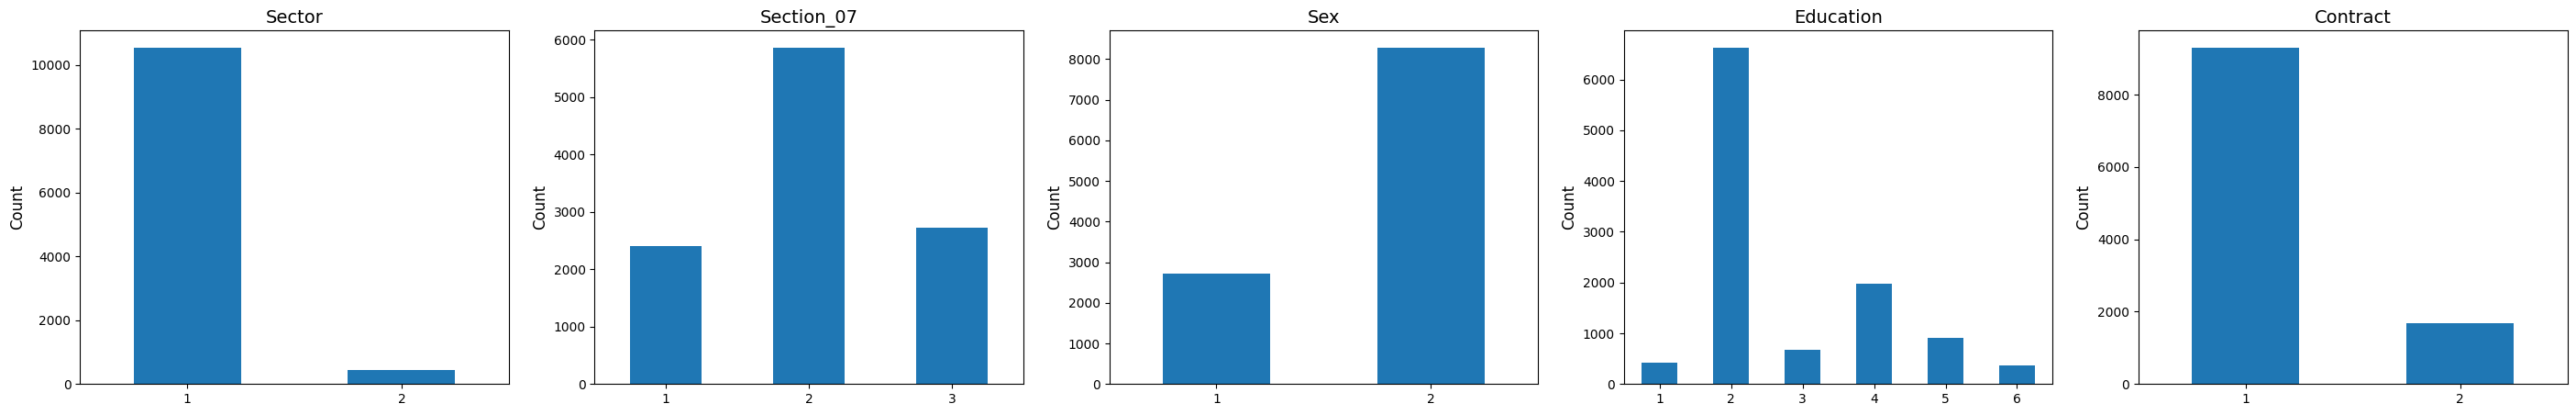

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(35, 5))
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
for i, var in enumerate(qual_vars):
  (
  data[var]
  .value_counts()
  .sort_index()
  .plot(kind='bar', ax=axs[i])
  )
  axs[i].set_title(var.capitalize(), fontsize=14)
  axs[i].set_xlabel('')
  axs[i].set_ylabel('Count', fontsize=12)
  axs[i].tick_params(axis='x', rotation=0)
plt.show()

#### Legend


- Sector  
1 - Public  
2 - Private

- Section_07 (NACE section)  
1 - Public Administration and Defence; Compulsory Social Security  
2 - Education  
3 - Human Health and Social Work Activities  

- Sex  
1 - Man  
2 - Woman

- Education  
1 – doctorate  
2 – higher  
3 – post-secondary  
4 – secondary  
5 – basic vocational  
6 – middle school and below

- Contract  
1 - for an indefinite period  
2 - for a definite period

### Comments

- **Sector**  
  The data is heavily biased towards public sector workers (96%).
- **Section_07**  
  Around half of the workers work in the education sector (53%), with the rest being fairly evenly distributed into public administration (22%) and human health (25%).
- **Sex**  
  The vast majority of the workers are women (75%).
- **Education**  
  The majority of the workers have higher education (60%), with secondary being the second most frequent education level (18%).
- **Contract**  
  Most of the workers are employed for an indefinite period (85%).

In [ ]:
# Calculate percentages
sector_counts = (
    data['sector']
    .value_counts()
    .to_dict()
)
public_percent = round(sector_counts[1] / sum(sector_counts.values()) * 100)
private_percent = round(sector_counts[2] / sum(sector_counts.values()) * 100)
print(f'Sector: {public_percent}% public, {private_percent}% private')

section_07_counts = (
    data['section_07']
    .value_counts()
    .to_dict()
)
public_admin_percent = round(section_07_counts[1] / sum(section_07_counts.values()) * 100)
education_percent = round(section_07_counts[2] / sum(section_07_counts.values()) * 100)
human_health_percent = round(section_07_counts[3] / sum(section_07_counts.values()) * 100)
print(f'Section 07: {public_admin_percent}% public admin, {education_percent}% education, {human_health_percent}% human health')

sex_counts = (
    data['sex']
    .value_counts()
    .to_dict()
)
man_percent = round(sex_counts[1] / sum(sex_counts.values()) * 100)
woman_percent = round(sex_counts[2] / sum(sex_counts.values()) * 100)
print(f'Sex: {man_percent}% man, {woman_percent}% woman')

education_counts = (
    data['education']
    .value_counts()
    .to_dict()
)
doctorate_percent = round(education_counts[1] / sum(education_counts.values()) * 100)
higher_percent = round(education_counts[2] / sum(education_counts.values()) * 100)
post_secondary_percent = round(education_counts[3] / sum(education_counts.values()) * 100)
secondary_percent = round(education_counts[4] / sum(education_counts.values()) * 100)
basic_vocational_percent = round(education_counts[5] / sum(education_counts.values()) * 100)
middle_school_percent = round(education_counts[6] / sum(education_counts.values()) * 100)
print(f'Education: {doctorate_percent}% doctorate, {higher_percent}% higher, {post_secondary_percent}% post-secondary, {secondary_percent}% secondary, {basic_vocational_percent}% basic vocational, {middle_school_percent}% middle school or below')

contract_counts = (
    data['contract']
    .value_counts()
    .to_dict()
)
for_indefinite_percent = round(contract_counts[1] / sum(contract_counts.values()) * 100)
for_period_percent = round(contract_counts[2] / sum(contract_counts.values()) * 100)
print(f'Contract: {for_period_percent}% for a definite period, {for_indefinite_percent}% for an indefinite period')

Sector: 96% public, 4% private
Section 07: 22% public admin, 53% education, 25% human health
Sex: 25% man, 75% woman
Education: 4% doctorate, 60% higher, 6% post-secondary, 18% secondary, 8% basic vocational, 3% middle school or below
Contract: 15% for a definite period, 85% for an indefinite period


## Quantitative variables

### Histograms

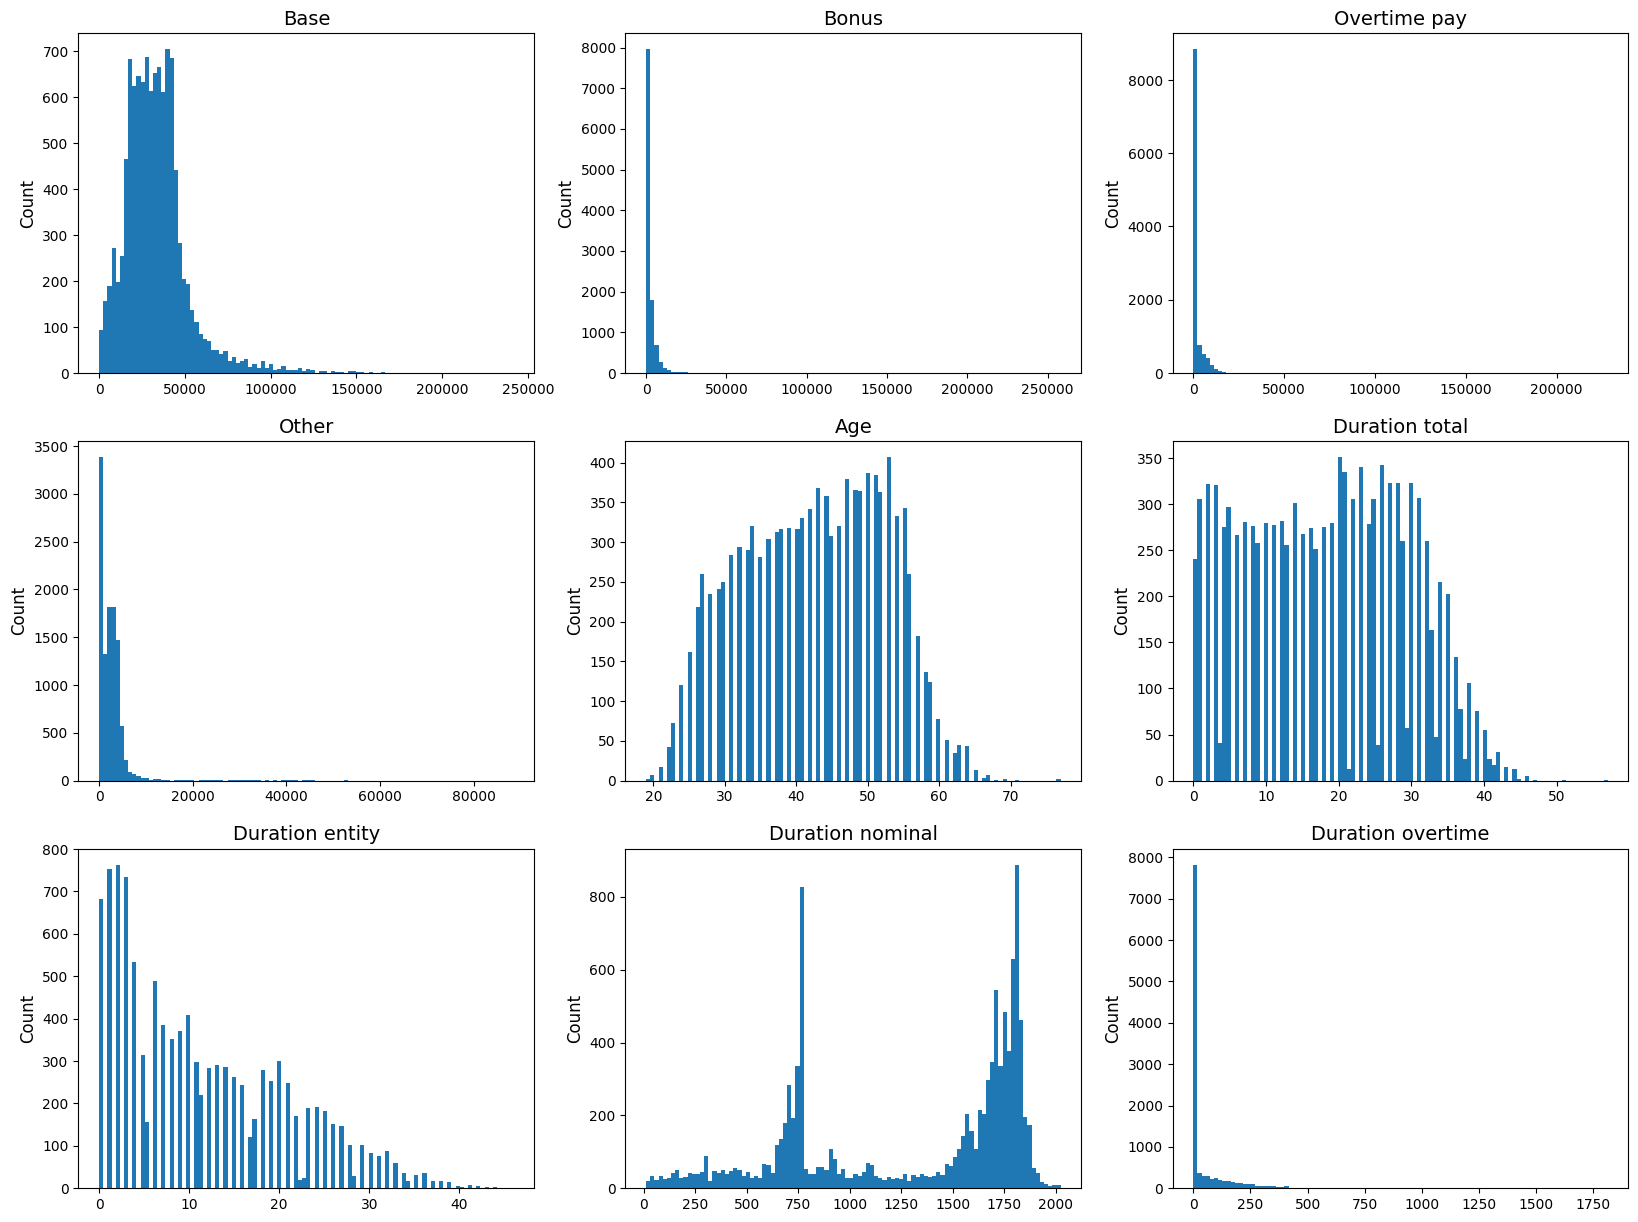

In [ ]:
N_BINS = 100

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
for i, var in enumerate(quant_vars):
  (
  data[var]
  .plot(kind='hist', bins=N_BINS, ax=axs[i // 3, i % 3])
  )
  axs[i // 3, i % 3].set_title(var.capitalize().replace('_', ' '), fontsize=14)
  axs[i // 3, i % 3].set_xlabel('')
  axs[i // 3, i % 3].set_ylabel('Count', fontsize=12)
  axs[i // 3, i % 3].tick_params(axis='x', rotation=0)
plt.show()

### Comments

- **Bonus**, **Overtime pay**, **Other** and **Duration overtime** histograms look very similar. They suggest that most workers work little to no overtime and do not recieve much compensation over their base salary. However it must be noted that there are some workers that do a lot of overtime and get high bonuses, overtime pay and other forms of additional compensation.
- **Duration nominal** histogram has two visible peaks around 750 and 1750 hours worked per year with all the other values being rare and fairly uniform. This suggest that most workers work a similar number of hours. Additionally if we divide the number of hours worked indicated by those peaks by the number of working days in Poland in 2010 (249 days), we get approximately 3 and 7 hours daily respectively, which could correspond to standard half-time and full-time employment.
- **Age** histogram looks similar to a normal distribution with skewed ends that cut off around 23 and 65. The right cut off corelates with the maximal retirement age in Poland (65 for men, 60 for women). The polish law could also explain an absence of workers younger than 18.
- **Base** histogram shows that most workers' salaries do not exceed 50,000 PLN per year. With a small but notable minority earning up to around 150,000 PLN.
- **Duration total** histogram is pretty uniform with a visible slope starting at 30.
- **Duration entity** histogram looks similar to an exponential distribution.

### Box plots

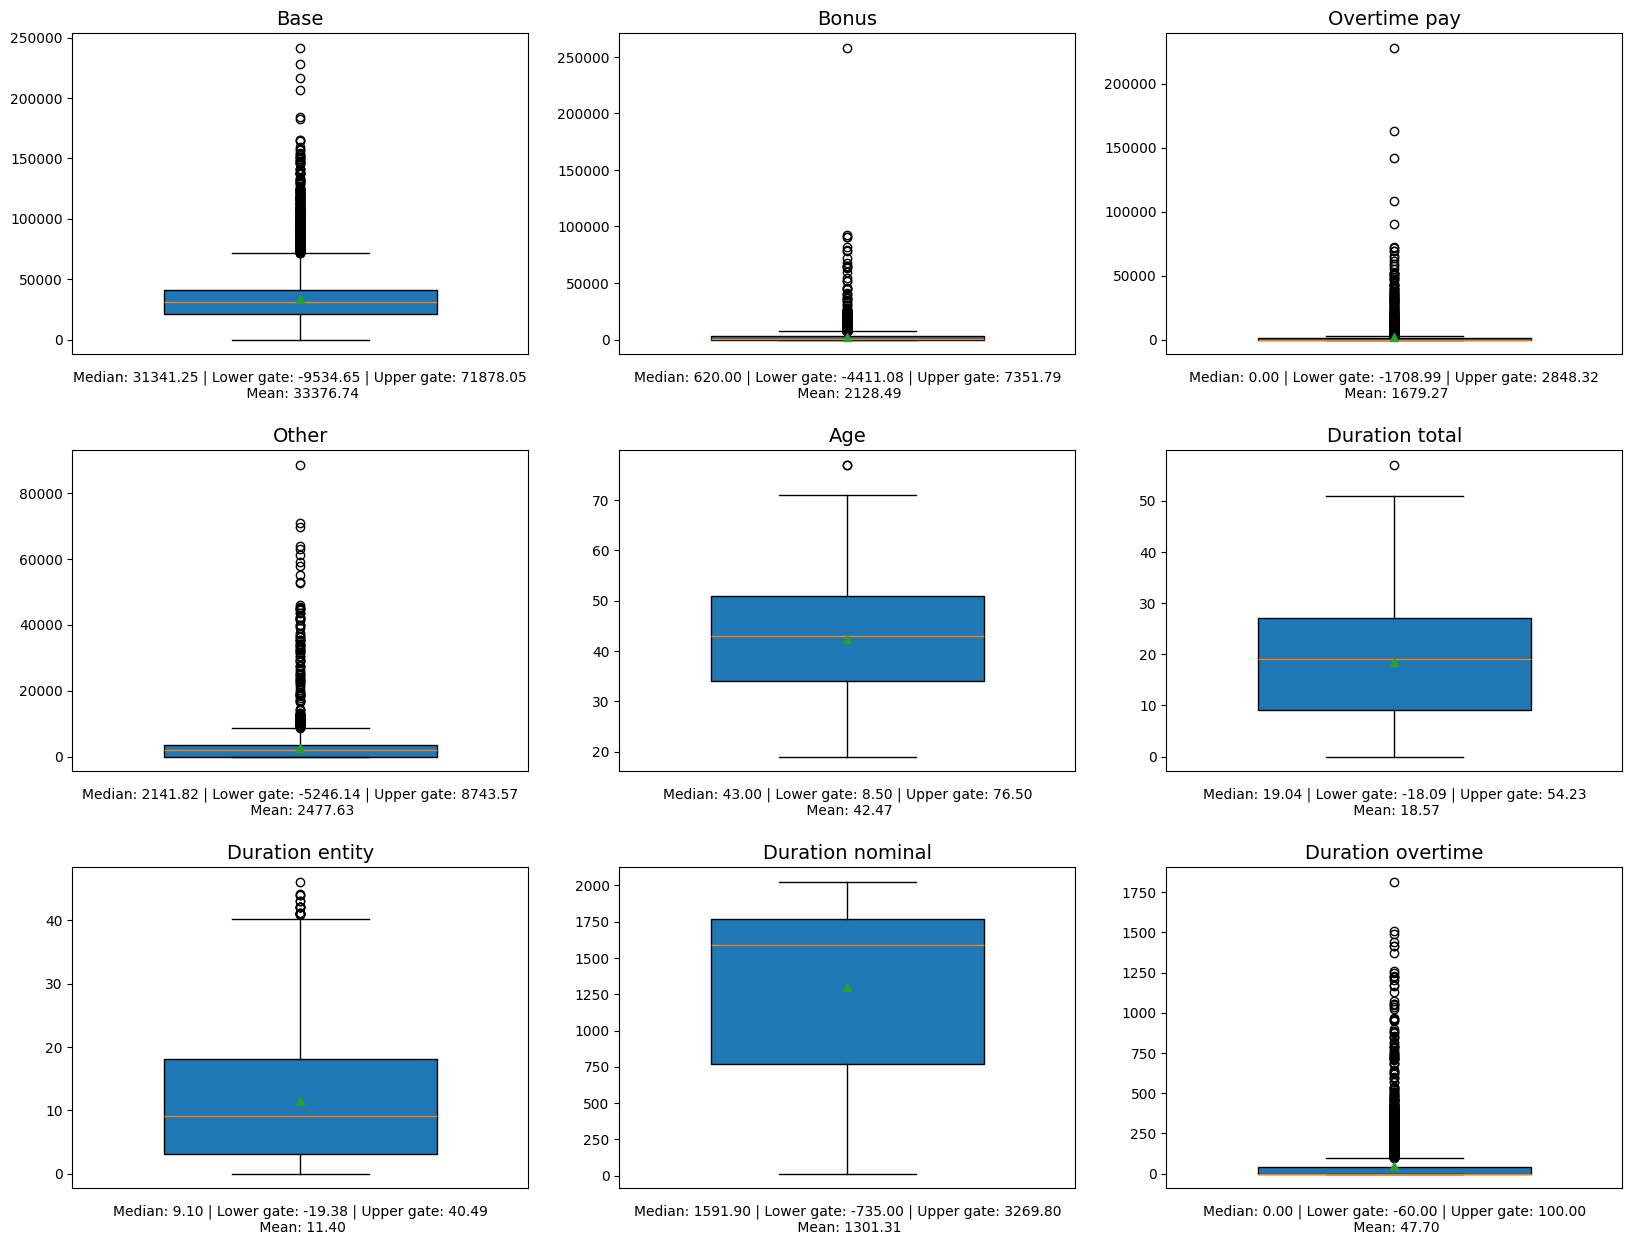

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']

for i, var in enumerate(quant_vars):
    ax = axs[i // 3, i % 3]
    values = data[var]

    ax.boxplot(values, vert=True, patch_artist=True, widths=0.6, showmeans=True)

    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_gate = q1 - 1.5 * iqr
    upper_gate = q3 + 1.5 * iqr
    mean = np.mean(values)
    median = np.median(values)

    ax.set_title(var.replace('_', ' ').capitalize(), fontsize=14)
    ax.set_xticks([])
    ax.set_ylabel('')

    description = f"Median: {median:.2f} | Lower gate: {lower_gate:.2f} | Upper gate: {upper_gate:.2f}\n Mean: {mean:.2f}"
    ax.text(0.5, -0.05, description, transform=ax.transAxes,
            fontsize=10, color='black', ha='center', va='top')

plt.subplots_adjust(hspace=0.3)
plt.show()

### Comments

- As context for observed **Base** salary, the minimum wage in Poland in 2010 was 15,804 PLN per year, the average salary was 38,699.76 PLN per year and the median salary was 34,881.36 PLN per year. It seems to be the case that workers from the dataset are generally underpaid if we consider the national statistics.
- The box plots clearly show that there are many outliers above the upper fence in the financial variables like **Base**, **Bonus** and **Other**, as well as further show that most workers do not work overtime (**Duration overtime**), while a minority does and earns a lot doing that (**Overtime pay**).
- **Age** and **Duration total** look even more symetrical than they did on their histograms.

# Clustering

## Euclidean distance

### Preprocessing

In [ ]:
data_cluster = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']

# MinMax scaling of quantitative variables
min_max_scaler = MinMaxScaler((0,1))
data_cluster[quant_vars] = min_max_scaler.fit_transform(data_cluster[quant_vars])

# Mapping binary variables to 0/1 instead of 1/2
binary_vars = ['sector', 'sex', 'contract']
data_cluster[binary_vars] = data_cluster[binary_vars].replace({1: 0, 2: 1})

# Dummy encoding not binary qualitative variables
data_cluster = pd.get_dummies(data_cluster, columns=['section_07', 'education'])
data_cluster = data_cluster.astype({
    'section_07_1': 'int64',
    'section_07_2': 'int64',
    'section_07_3': 'int64',
    'education_1': 'int64',
    'education_2': 'int64',
    'education_3': 'int64',
    'education_4': 'int64',
    'education_5': 'int64',
    'education_6': 'int64',
})

data_cluster.drop(labels=['section_07_1', 'education_1'], axis=1, inplace=True)  # Can be dropped, because it's implicitly encoded in the rest of dummy variables

### Comments

Before clustering using either k-means or agglomerative clustering we need to scale the data and properly manage qualitative variables.  
- For qualitative variables I decided to map the binary variables to 0/1 and perform dummy encoding for the rest.  
- For quantitative variables I decided to use min-max scaling and mapped all the variables to (0,1) range.  

Now all the data fits nicely in (0, 1) range and should behave well with the euclidean distance as the metric.  
  
// For quantitative variables I also tried standard, robust and logarithmic scaling, but struggled to make a good decision regarding the qualitative data with those scalers. Min-max performed best.
  
// Unforunately big number of dimensions (caused by dummy encoding) does not work well with clustering algorithms, but dimension reduction was introduced later in this course and I thought was not in scope of this assignment. On the other hand dropping the qualitative variables entirely seemed to be a bad choice considering they are more than 1/3 of the variables with some of the others being heavily correlated.

### Choosing k for k-means clustering

For 2 clusters the average silhouette score is 0.272
For 3 clusters the average silhouette score is 0.252
For 4 clusters the average silhouette score is 0.297
For 5 clusters the average silhouette score is 0.299
For 6 clusters the average silhouette score is 0.310
For 7 clusters the average silhouette score is 0.326



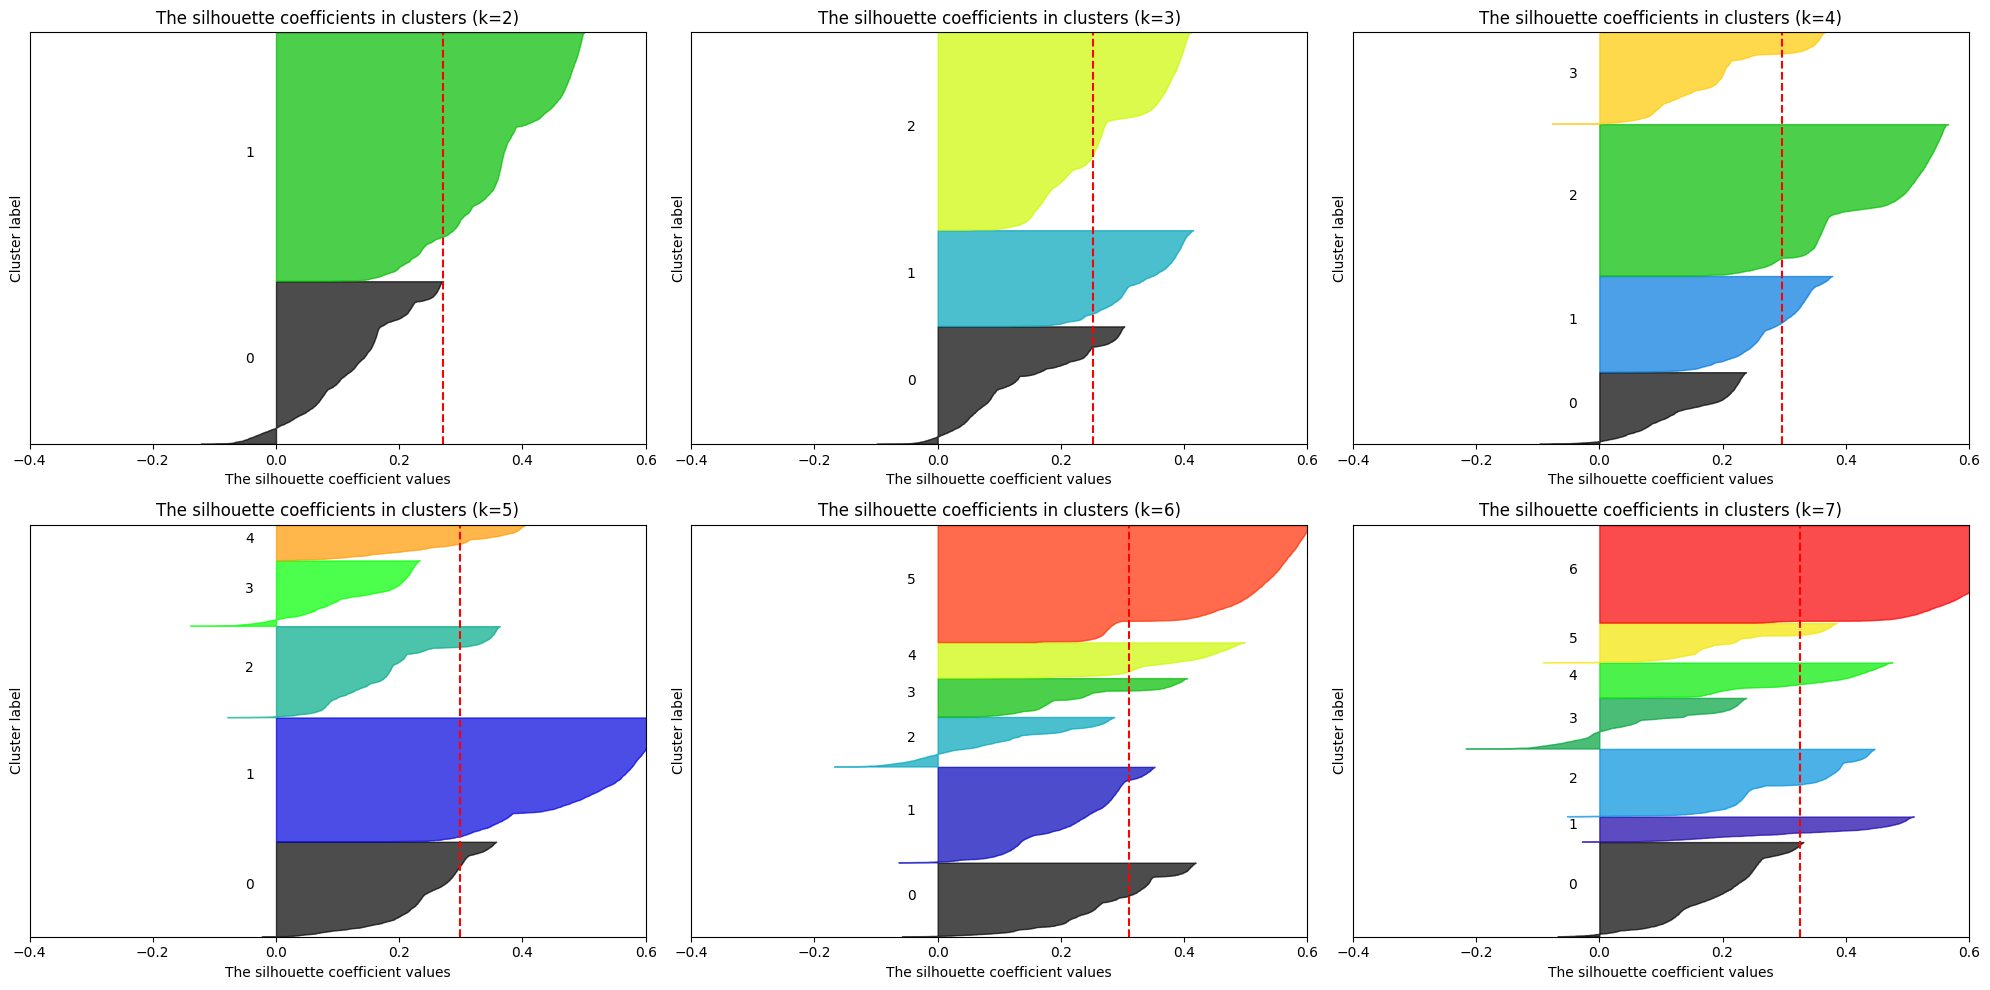

In [ ]:
# Code borrowed from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
k_range = [2, 3, 4, 5, 6, 7]
X = data_cluster
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i, k in enumerate(k_range):
    ax = axs[i]

    ax.set_xlim([-0.4, 0.6])
    ax.set_ylim([0, len(X) + (k + 1) * 10])

    kmeans = KMeans(n_clusters=k, n_init=RETRY, random_state=RANDOM_SEED)
    kmeans_labels = kmeans.fit_predict(X)

    silhouette_avg = silhouette_score(X, kmeans_labels, random_state=RANDOM_SEED)
    print(f'For {k} clusters the average silhouette score is {silhouette_avg:.3f}')

    sample_silhouette_values = silhouette_samples(X, kmeans_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title(f'The silhouette coefficients in clusters (k={k})')
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')

    ax.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax.set_yticks([])
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6])

plt.tight_layout()
print()
plt.show()

### Comments

The optimal k-means clustering is 7 clusters and has a silhouette score of 0.326. Which means that the clustering is rather weak. There clusters could be grouped into big and small ones - 0, 2 and 6 being the big ones.

// I capped the maximum number of clusters for interpretability's sake. Maybe a higher number of clusters would have a better score, but they wouldn't be of much help for making sense of the data.  


### K-means clustering

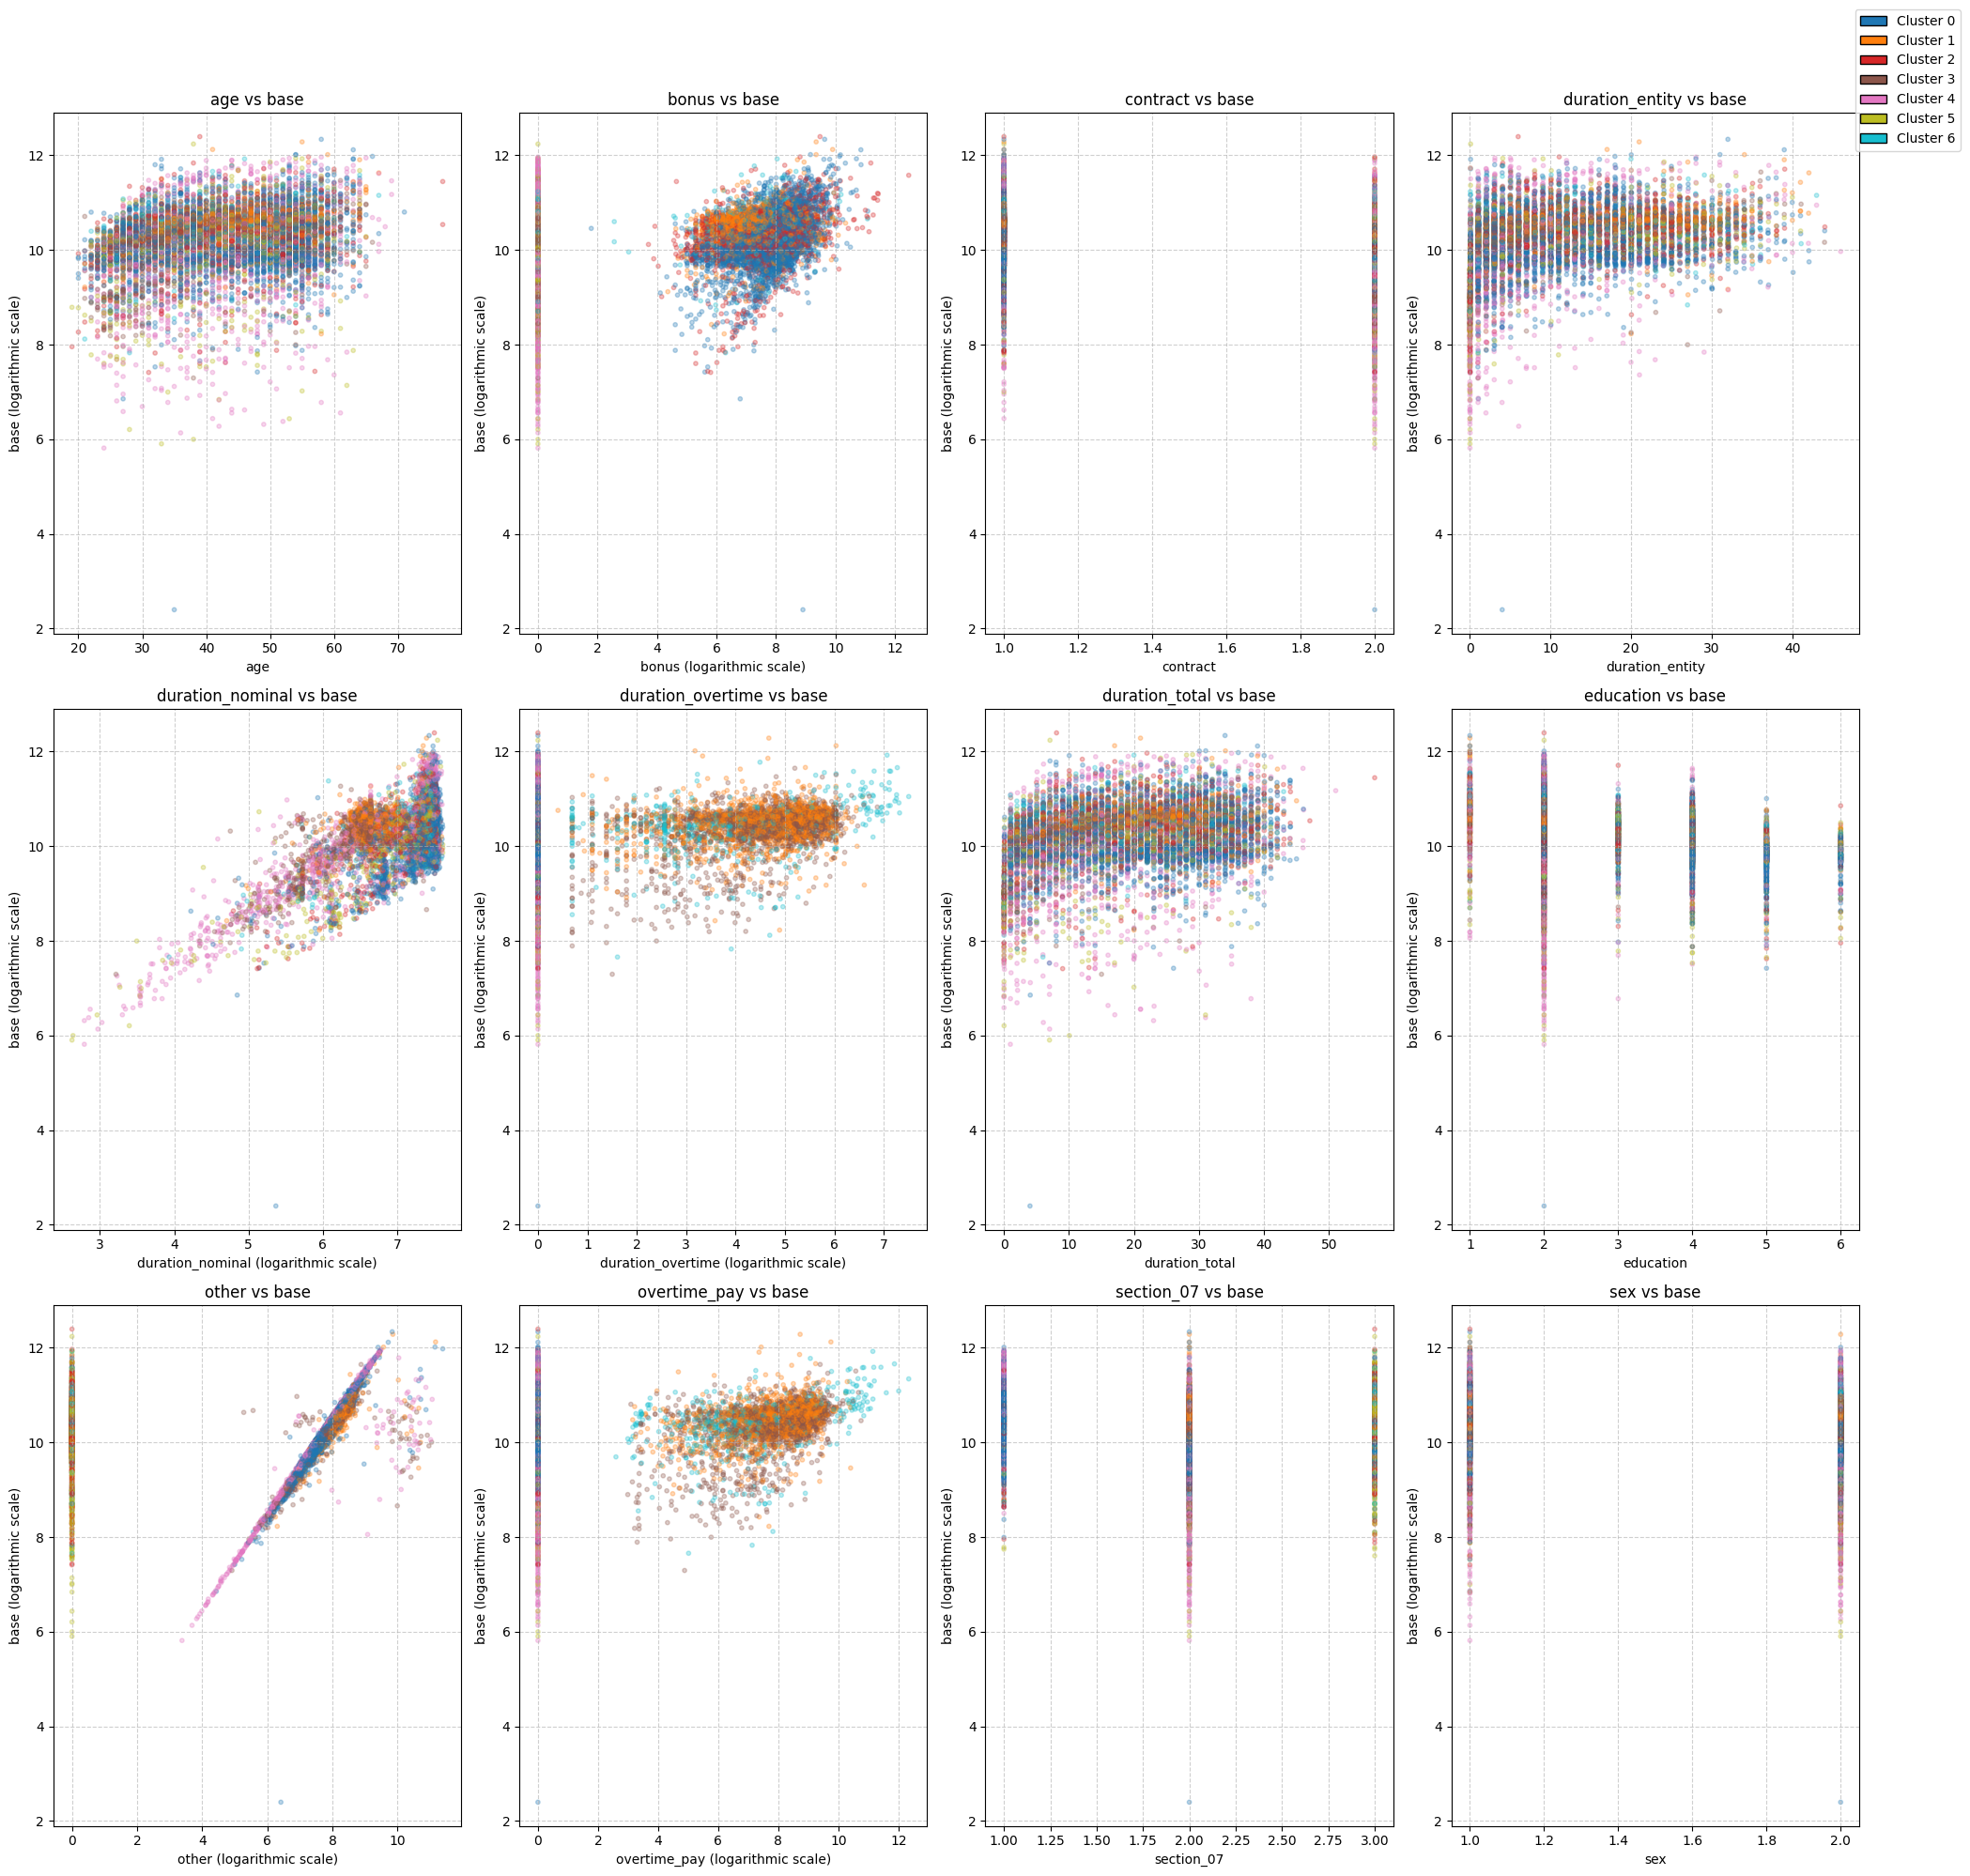

In [171]:
# Performing clustering
k = 7
kmeans = KMeans(n_clusters=k, n_init=RETRY, random_state=RANDOM_SEED)
kmeans_labels = kmeans.fit_predict(data_cluster)

# Plotting
plot_pairs = [
    ('age', 'base'),
    ('bonus', 'base'),
    ('contract', 'base'),
    ('duration_entity', 'base'),
    ('duration_nominal', 'base'),
    ('duration_overtime', 'base'),
    ('duration_total', 'base'),
    ('education', 'base'),
    ('other', 'base'),
    ('overtime_pay', 'base'),
    ('section_07', 'base'),
    ('sex', 'base'),
]
need_log_scaling = ['base', 'bonus', 'other', 'overtime_pay', 'duration_overtime', 'duration_nominal']
X = data
cmap_name = 'tab10'
cmap = plt.get_cmap(cmap_name)

fig, axes = plt.subplots(3, 4, figsize=(20, 20))
axes = axes.flatten()

for i, pair in enumerate(plot_pairs):
    x_var, y_var = pair
    ax = axes[i]

    plot_x = X[x_var]
    plot_y = X[y_var]

    if x_var in need_log_scaling:
        plot_x = np.log1p(plot_x)
        ax.set_xlabel(f'{x_var} (logarithmic scale)')
    else:
        ax.set_xlabel(x_var)

    if y_var in need_log_scaling:
        plot_y = np.log1p(plot_y)
        ax.set_ylabel(f'{y_var} (logarithmic scale)')
    else:
        ax.set_ylabel(y_var)

    colors = [cmap(label / (k - 1)) for label in range(k)]
    scatter = ax.scatter(plot_x, plot_y, c=[colors[l] for l in kmeans_labels], alpha=0.3, s=10)

    ax.set_title(f'{x_var} vs {y_var}')
    ax.grid(True, linestyle='--', alpha=0.6)

legend_handles = [Patch(facecolor=cmap(i / (k - 1)), edgecolor='black', label=f'Cluster {i}') for i in range(k)]
fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Comments

- I decided to plot **base** against all the other variables, because it is the most important one. I left out **sector** plot, becuase the private sector workers are only 4% of the data and assumed that the difference wouldn't be noticed by the clustering algorithms.  
- The logarithmic scale is used for some of the variables, because of their distributions mentioned in the previous chapter.

// After plotting, it seems that even 7 clusters are difficult to interpret.

### Hierarchical clustering dendrogram

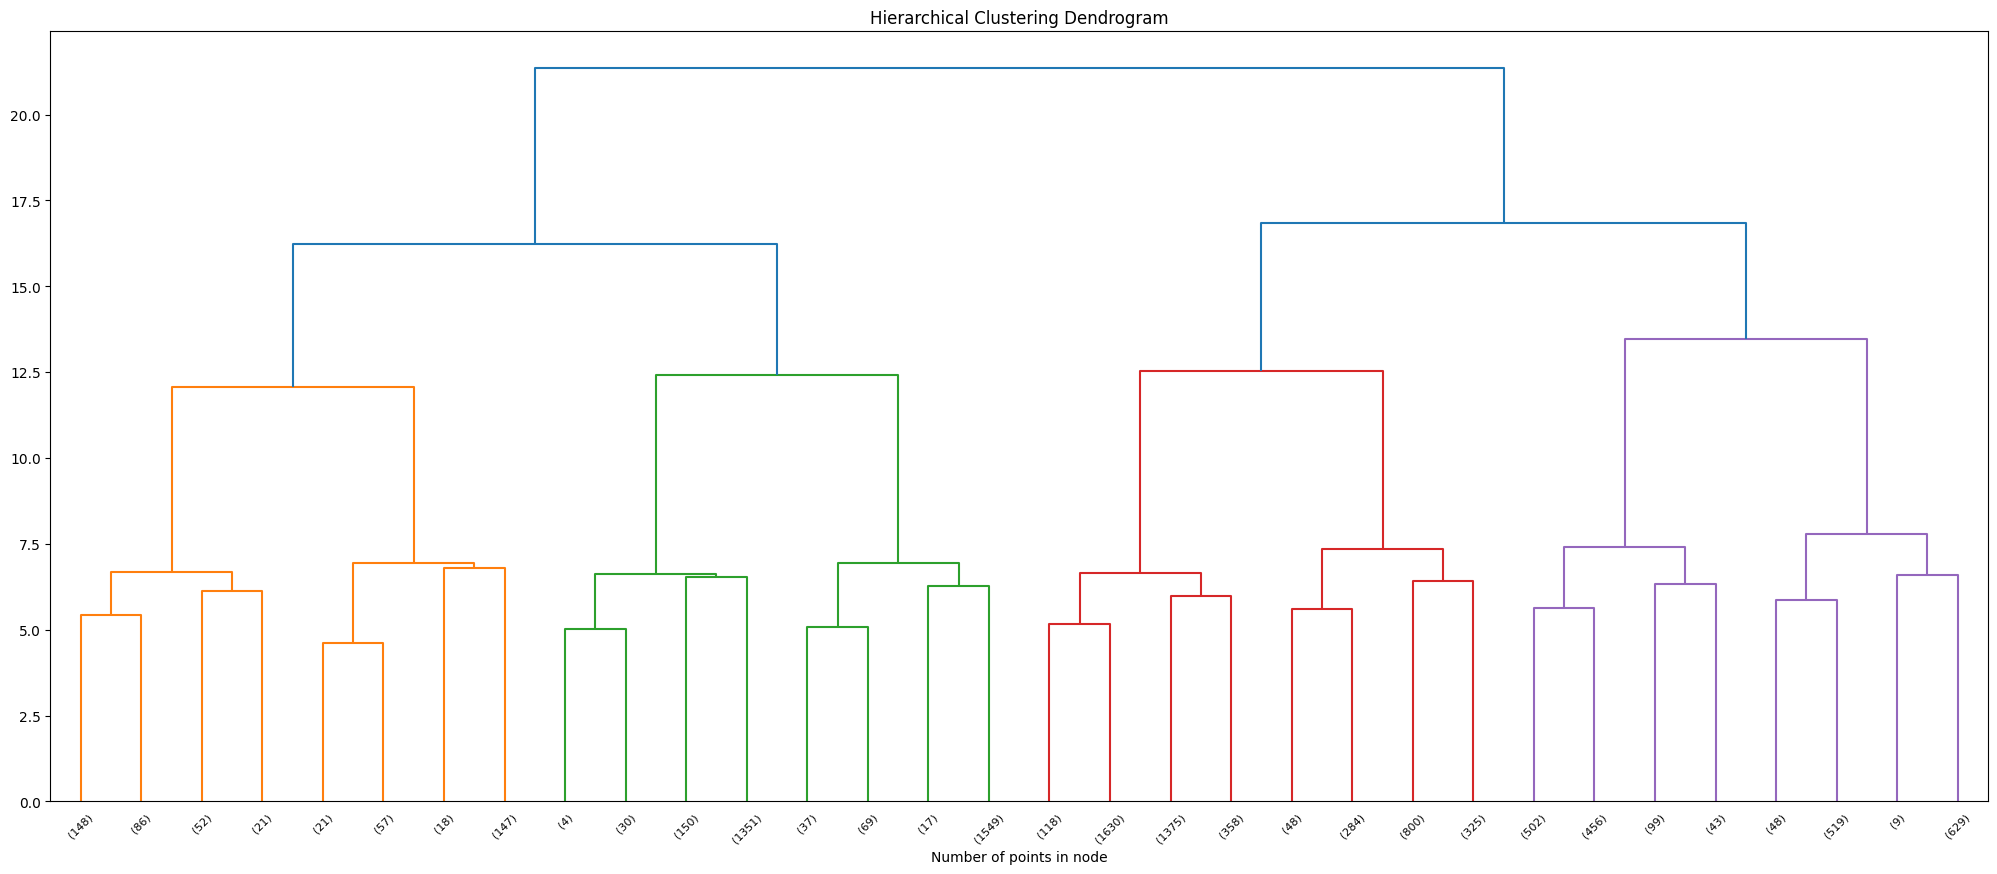

In [158]:
# Code borrowed from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    hierarchy.dendrogram(linkage_matrix, **kwargs)


X = data_cluster

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(X)
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel('Number of points in node')
plt.show()

### Choosing best number of clusters

I set linkage equal to 'complete', because after experimenting with gower distance (in the second part of this chapter) it turned out that it performed significantly better than the other linkage methods. The conclusion stands for euclidean distance as well (in this dataset).

For 2 clusters the average silhouette score is 0.482
For 3 clusters the average silhouette score is 0.502
For 4 clusters the average silhouette score is 0.511
For 5 clusters the average silhouette score is 0.526
For 6 clusters the average silhouette score is 0.661
For 7 clusters the average silhouette score is 0.740



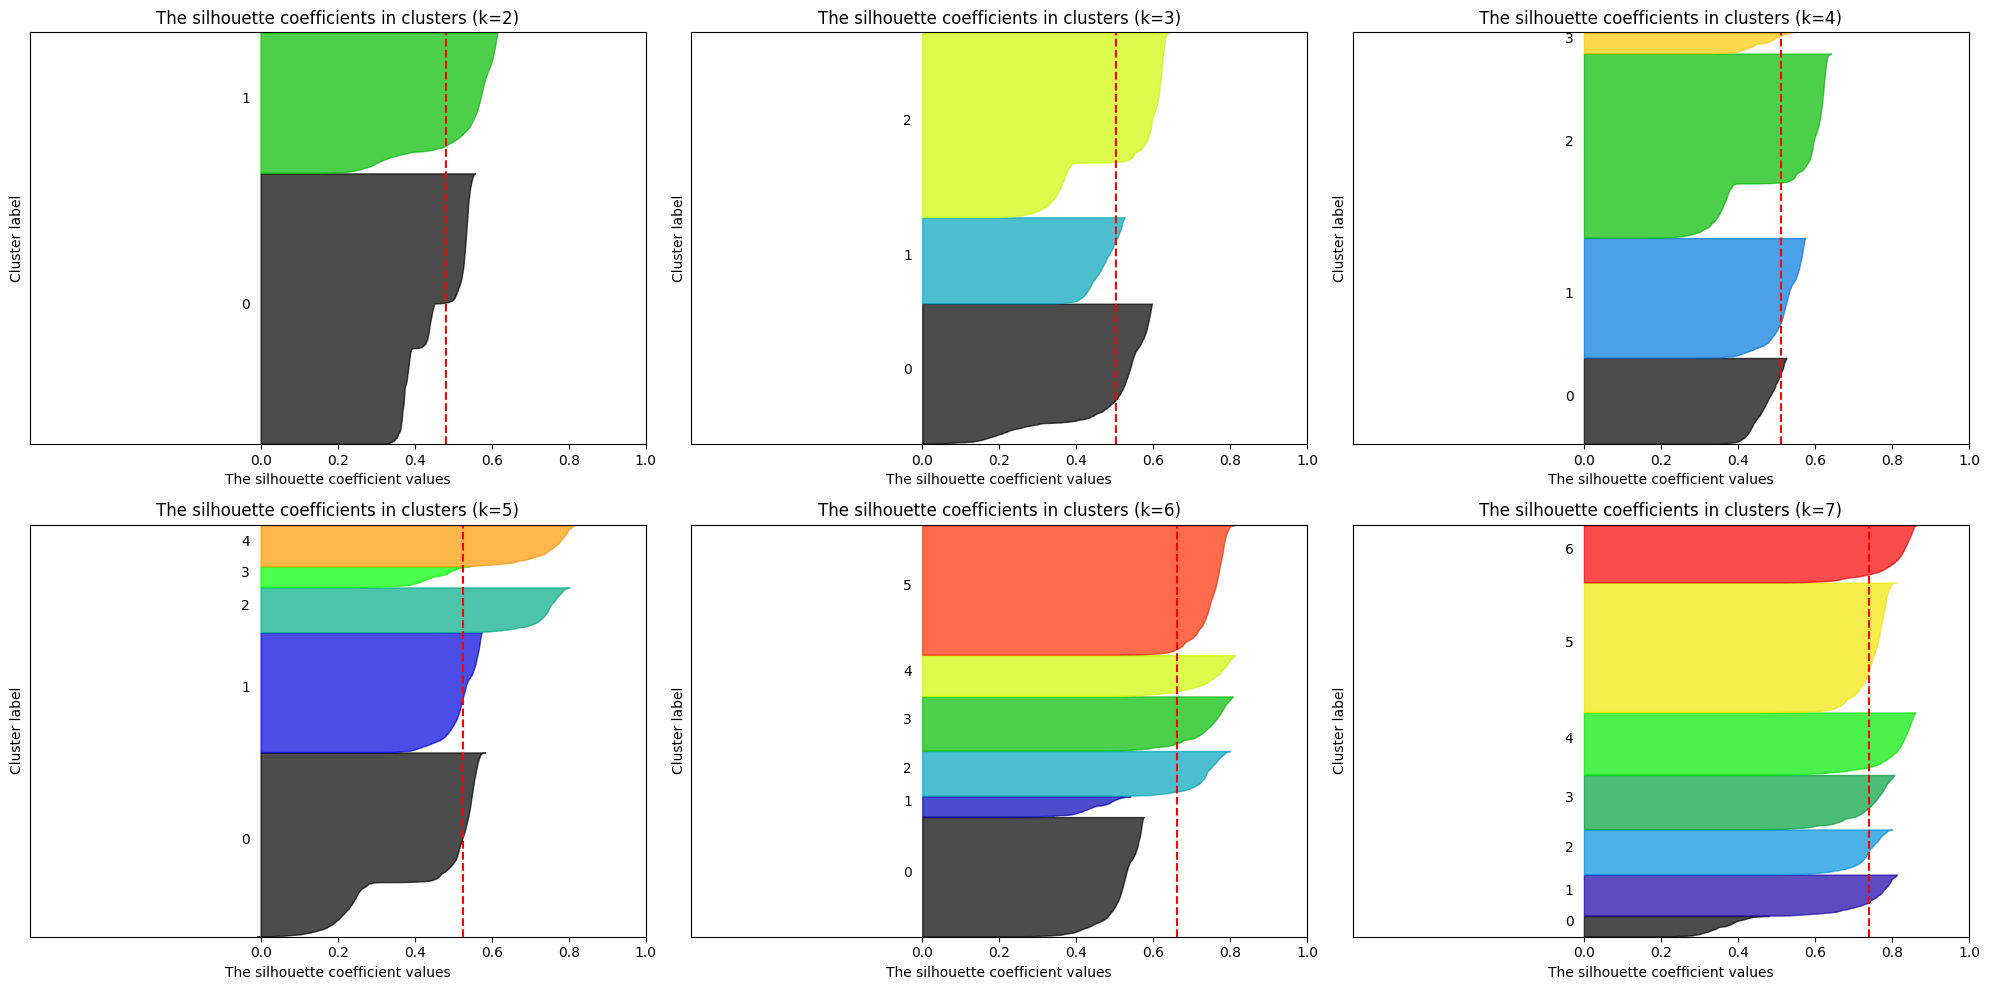

In [173]:
k_range = [2, 3, 4, 5, 6, 7]
X = data_cluster
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i, k in enumerate(k_range):
    ax = axs[i]

    ax.set_xlim([-0.6, 0.8])
    ax.set_ylim([0, len(X) + (k + 1) * 10])

    agglomerative = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='complete')
    agglomerative_labels = agglomerative.fit_predict(X)

    silhouette_avg = silhouette_score(X, agglomerative_labels, metric='euclidean', random_state=RANDOM_SEED)
    print(f'For {k} clusters the average silhouette score is {silhouette_avg:.3f}')

    sample_silhouette_values = silhouette_samples(X, agglomerative_labels, metric='euclidean')

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[agglomerative_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title(f'The silhouette coefficients in clusters (k={k})')
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')

    ax.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax.set_yticks([])
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
print()
plt.show()

### Agglomerative clustering

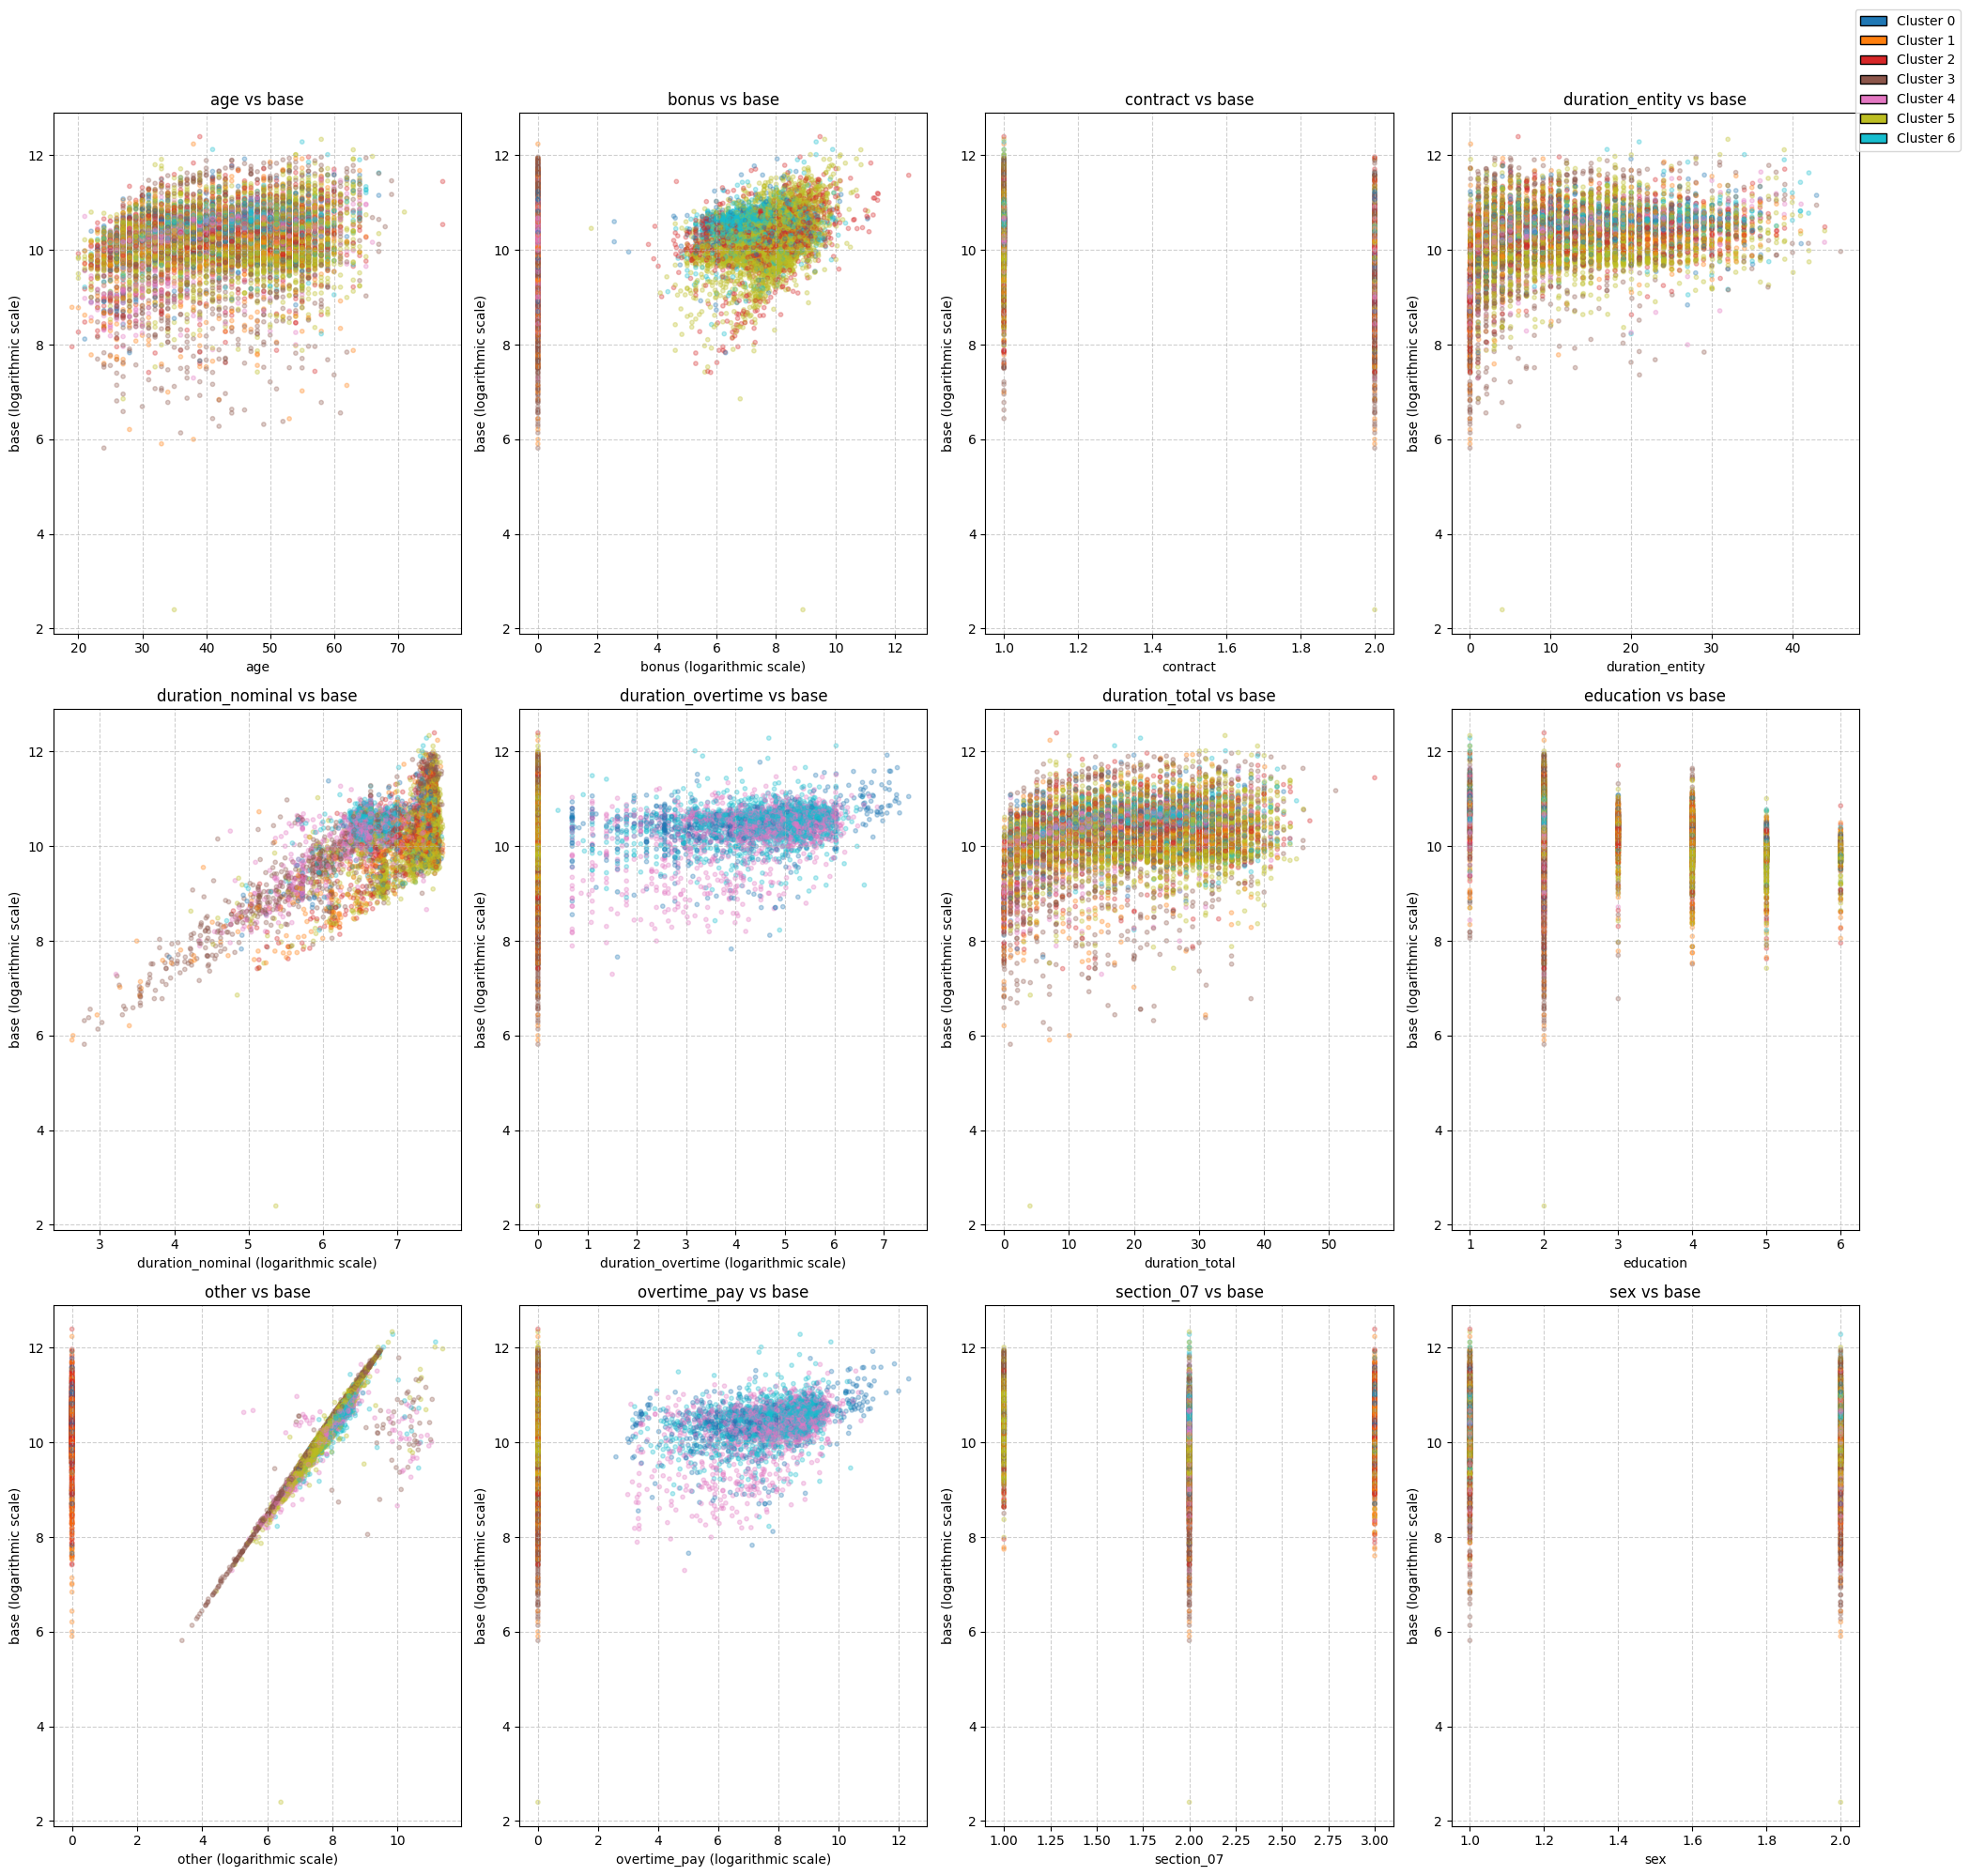

In [174]:
# Performing clustering
n_clusters = 7
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
agglomerative_labels = agglomerative.fit_predict(data_cluster)

# Plotting
plot_pairs = [
    ('age', 'base'),
    ('bonus', 'base'),
    ('contract', 'base'),
    ('duration_entity', 'base'),
    ('duration_nominal', 'base'),
    ('duration_overtime', 'base'),
    ('duration_total', 'base'),
    ('education', 'base'),
    ('other', 'base'),
    ('overtime_pay', 'base'),
    ('section_07', 'base'),
    ('sex', 'base')
]
need_log_scaling = ['base', 'bonus', 'other', 'overtime_pay', 'duration_overtime', 'duration_nominal']
X = data

cmap_name = 'tab10'
cmap = plt.get_cmap(cmap_name)

fig, axes = plt.subplots(3, 4, figsize=(20, 20))
axes = axes.flatten()

for i, pair in enumerate(plot_pairs):
    x_var, y_var = pair
    ax = axes[i]

    plot_x = X[x_var]
    plot_y = X[y_var]

    if x_var in need_log_scaling:
        plot_x = np.log1p(plot_x)
        ax.set_xlabel(f'{x_var} (logarithmic scale)')
    else:
        ax.set_xlabel(x_var)

    if y_var in need_log_scaling:
        plot_y = np.log1p(plot_y)
        ax.set_ylabel(f'{y_var} (logarithmic scale)')
    else:
        ax.set_ylabel(y_var)

    colors = [cmap(label / (n_clusters - 1)) for label in range(n_clusters)]
    scatter = ax.scatter(plot_x, plot_y, c=[colors[l] for l in agglomerative_labels], alpha=0.3, s=10)

    ax.set_title(f'{x_var} vs {y_var}')
    ax.grid(True, linestyle='--', alpha=0.6)

legend_handles = [Patch(facecolor=cmap(i / (n_clusters - 1)), edgecolor='black', label=f'Cluster {i}') for i in range(n_clusters)]
fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Comments

- Agglomerative clustering performed a lot better than k-means with the best clustering (7 clusters) reaching 0.74 silhouette score - an ok clustering.
- Exactly the same problem, of 7 clusters being hard to interpret, as before.  
  
// I will try to interpret the best clustering in the end of this chapter for a smaller amount of clusters.

## Gower's distance

### Preprocessing

In [175]:
data_cluster = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
epsilon = 1e-6

# Log scaling of quantitative variables
data_cluster[quant_vars] = np.log10(data_cluster[quant_vars] + epsilon)  # adding epsilon to avoid log(0) = -inf issue

In [149]:
# Calculating distances
# Definition: https://en.wikipedia.org/wiki/Gower%27s_distance
# Source: https://github.com/wwwjk366/gower/blob/master/gower/gower_dist.py

cat_features = np.array([False] * 4 + [True] * 5 + [False] * 5)

# Calculate the Gower distance matrix
gower_distance_matrix = gower.gower_matrix(data_cluster, cat_features=cat_features)

### Comments

- Gower's distance is a metric that calculates the manhattan distance of quantitative variables and adds additional distance for every qualitative variable that is different between compared data points.  
- The new metric allows us to leave qualitative variables as they are and only scale the quantitative ones.
- Quantitative variables are logarithmically scaled, becaues they differ in orders of magnitude.  
  
// Standard and robust scaling were tested for quantitative variables as well, but they performed worse than logarithmic.

### Choosing best number of clusters and linkage

#### Linkage: single

For 2 clusters the average silhouette score is 0.269
For 3 clusters the average silhouette score is 0.198
For 4 clusters the average silhouette score is 0.193
For 5 clusters the average silhouette score is 0.171
For 6 clusters the average silhouette score is 0.159
For 7 clusters the average silhouette score is 0.155



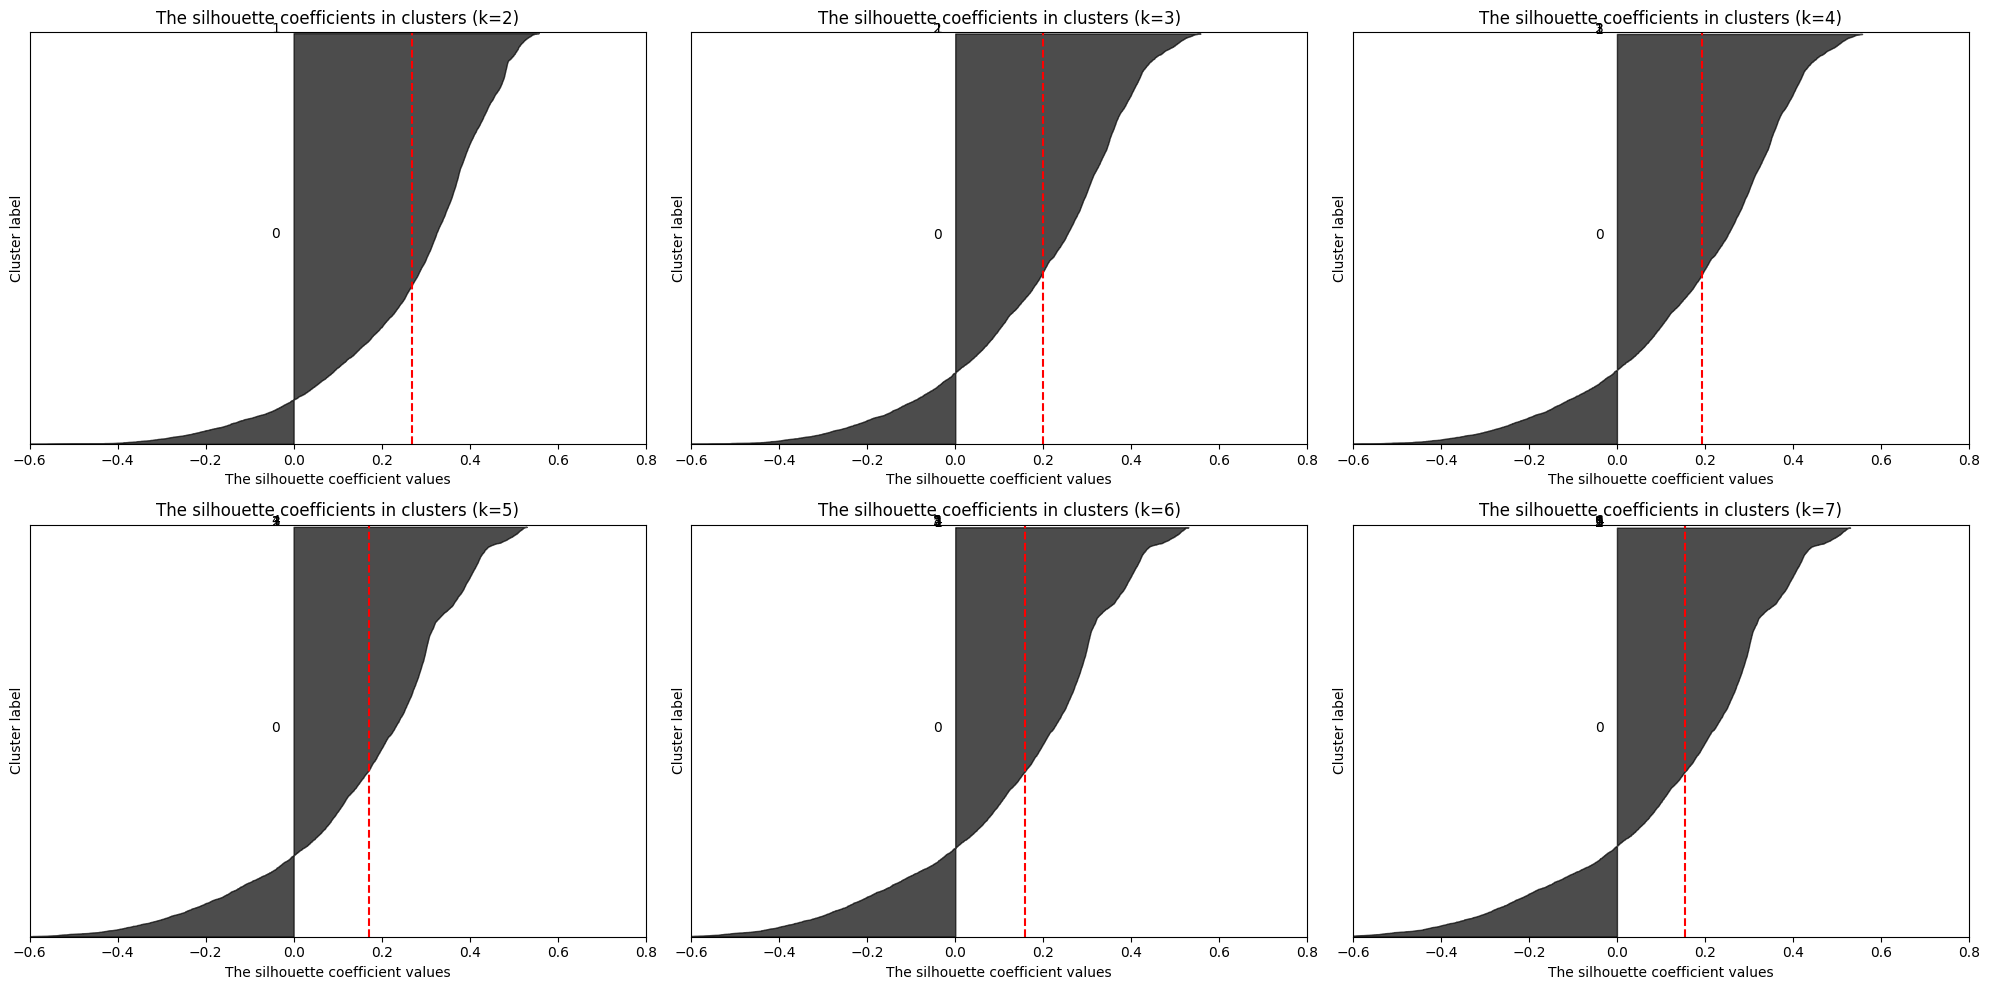

In [150]:
k_range = [2, 3, 4, 5, 6, 7]
X = gower_distance_matrix
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i, k in enumerate(k_range):
    ax = axs[i]

    ax.set_xlim([-0.6, 0.8])
    ax.set_ylim([0, len(X) + (k + 1) * 10])

    agglomerative = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='single')
    agglomerative_labels = agglomerative.fit_predict(X)

    silhouette_avg = silhouette_score(X, agglomerative_labels, metric='precomputed', random_state=RANDOM_SEED)
    print(f'For {k} clusters the average silhouette score is {silhouette_avg:.3f}')

    sample_silhouette_values = silhouette_samples(X, agglomerative_labels, metric='precomputed')

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[agglomerative_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title(f'The silhouette coefficients in clusters (k={k})')
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')

    ax.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax.set_yticks([])
    ax.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])

plt.tight_layout()
print()
plt.show()

#### Linkage: average

For 2 clusters the average silhouette score is 0.264
For 3 clusters the average silhouette score is 0.320
For 4 clusters the average silhouette score is 0.302
For 5 clusters the average silhouette score is 0.333
For 6 clusters the average silhouette score is 0.318
For 7 clusters the average silhouette score is 0.289



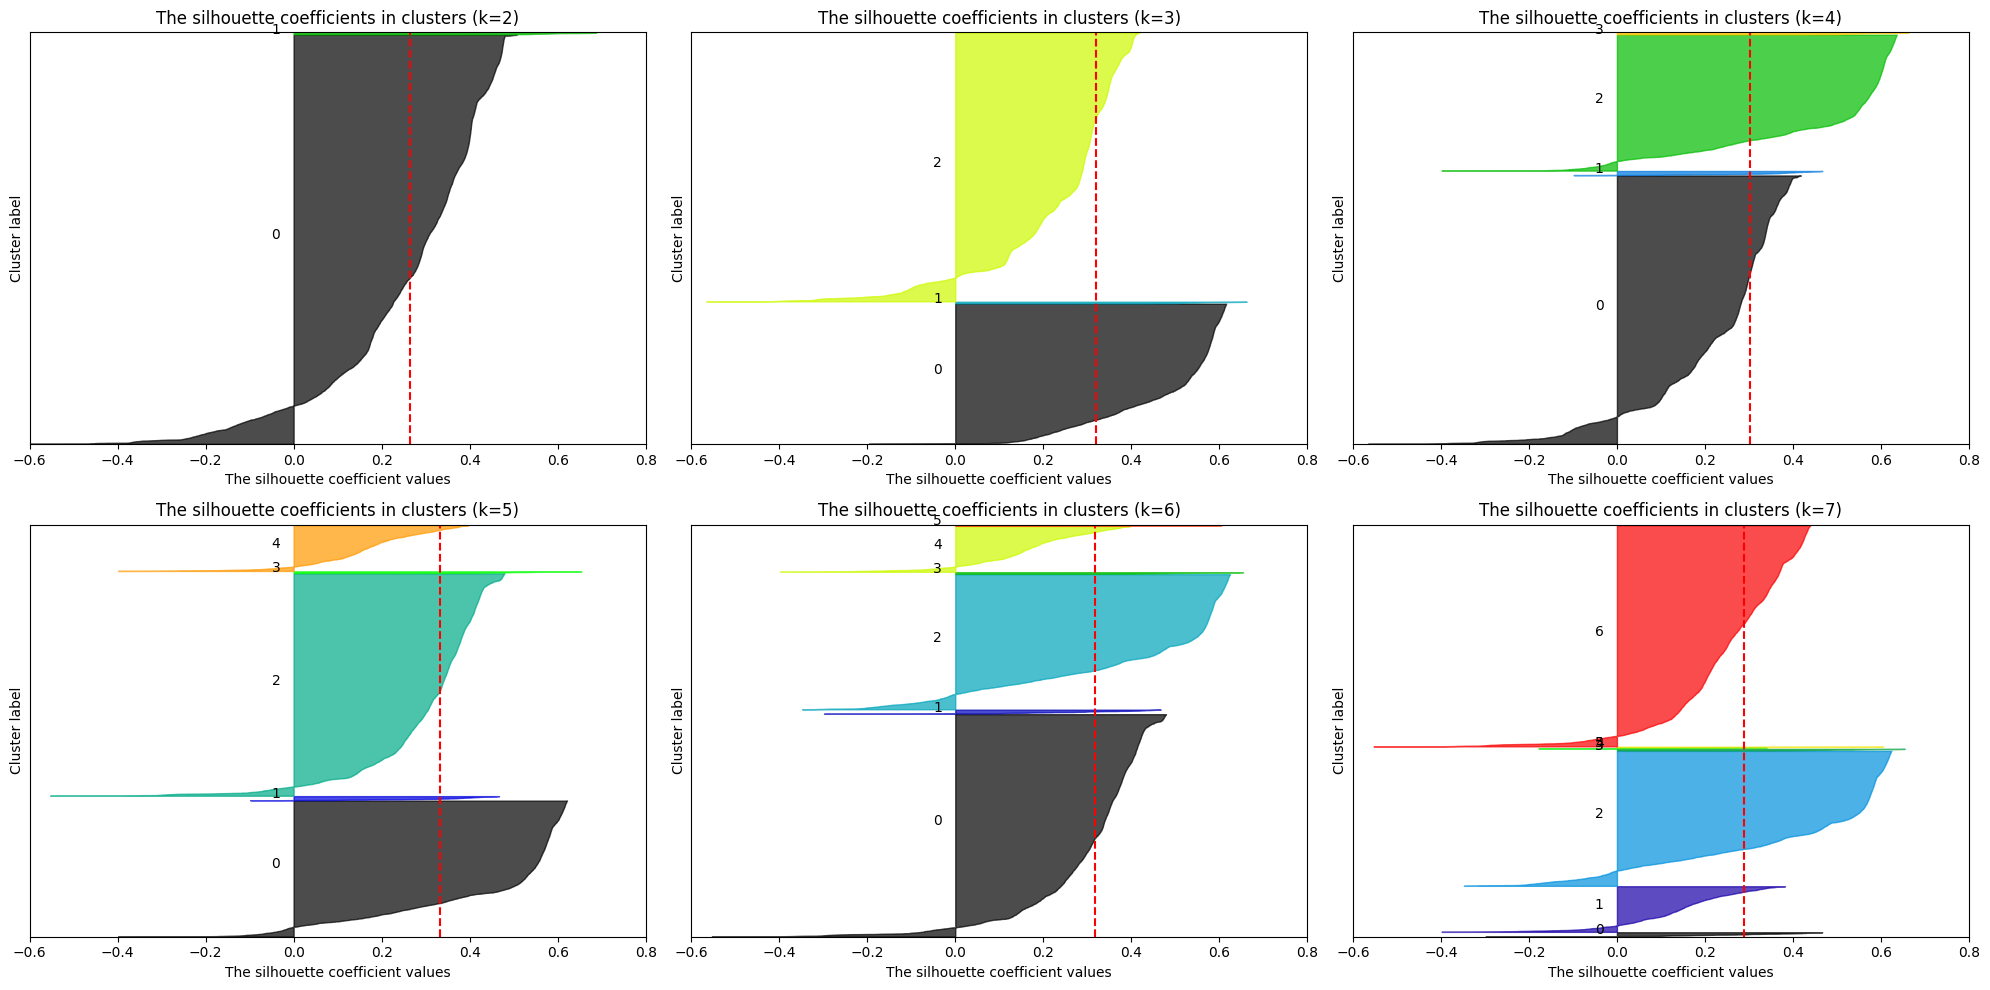

In [151]:
k_range = [2, 3, 4, 5, 6, 7]
X = gower_distance_matrix
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i, k in enumerate(k_range):
    ax = axs[i]

    ax.set_xlim([-0.6, 0.8])
    ax.set_ylim([0, len(X) + (k + 1) * 10])

    agglomerative = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    agglomerative_labels = agglomerative.fit_predict(X)

    silhouette_avg = silhouette_score(X, agglomerative_labels, metric='precomputed', random_state=RANDOM_SEED)
    print(f'For {k} clusters the average silhouette score is {silhouette_avg:.3f}')

    sample_silhouette_values = silhouette_samples(X, agglomerative_labels, metric='precomputed')

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[agglomerative_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title(f'The silhouette coefficients in clusters (k={k})')
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')

    ax.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax.set_yticks([])
    ax.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])

plt.tight_layout()
print()
plt.show()

#### Linkage: complete

For 2 clusters the average silhouette score is 0.251
For 3 clusters the average silhouette score is 0.326
For 4 clusters the average silhouette score is 0.236
For 5 clusters the average silhouette score is 0.224
For 6 clusters the average silhouette score is 0.188
For 7 clusters the average silhouette score is 0.169



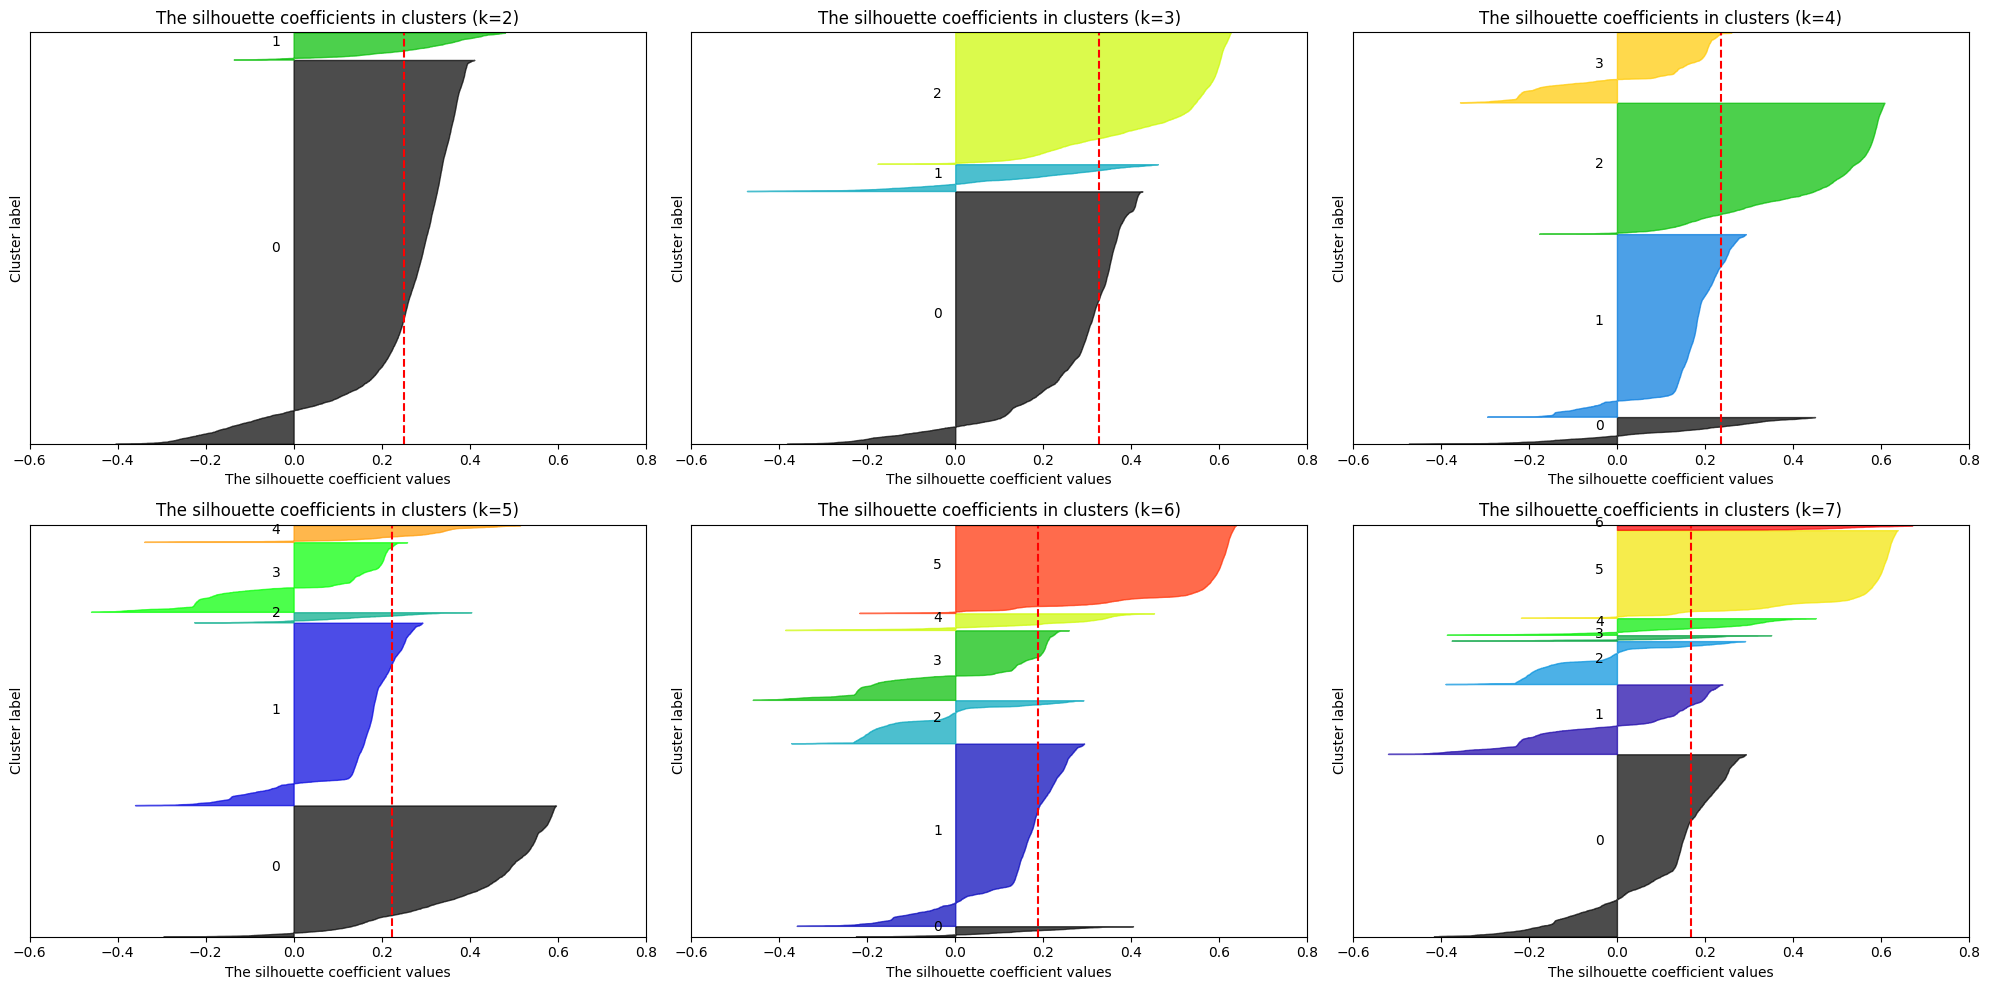

In [152]:
k_range = [2, 3, 4, 5, 6, 7]
X = gower_distance_matrix
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i, k in enumerate(k_range):
    ax = axs[i]

    ax.set_xlim([-0.6, 0.8])
    ax.set_ylim([0, len(X) + (k + 1) * 10])

    agglomerative = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    agglomerative_labels = agglomerative.fit_predict(X)

    silhouette_avg = silhouette_score(X, agglomerative_labels, metric='precomputed', random_state=RANDOM_SEED)
    print(f'For {k} clusters the average silhouette score is {silhouette_avg:.3f}')

    sample_silhouette_values = silhouette_samples(X, agglomerative_labels, metric='precomputed')

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[agglomerative_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title(f'The silhouette coefficients in clusters (k={k})')
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')

    ax.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax.set_yticks([])
    ax.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])

plt.tight_layout()
print()
plt.show()

### Comments

- Gower's distance turns out to provide significantly smaller silhouette scores than the euclidean, for agglomerative clustering, but still managed to get a better clustering (3 clusters, linkage=complete) than k-means.
- Different linkage methods heavily influence sizes of clusters. *single* made basically degenrated clusters with nearly all of the datapoints in one cluster. *average* was a bit more balanced, but still many clusters were comically small. *complete* linkage's clusterings were the most balanced.  

### Agglomerative clustering

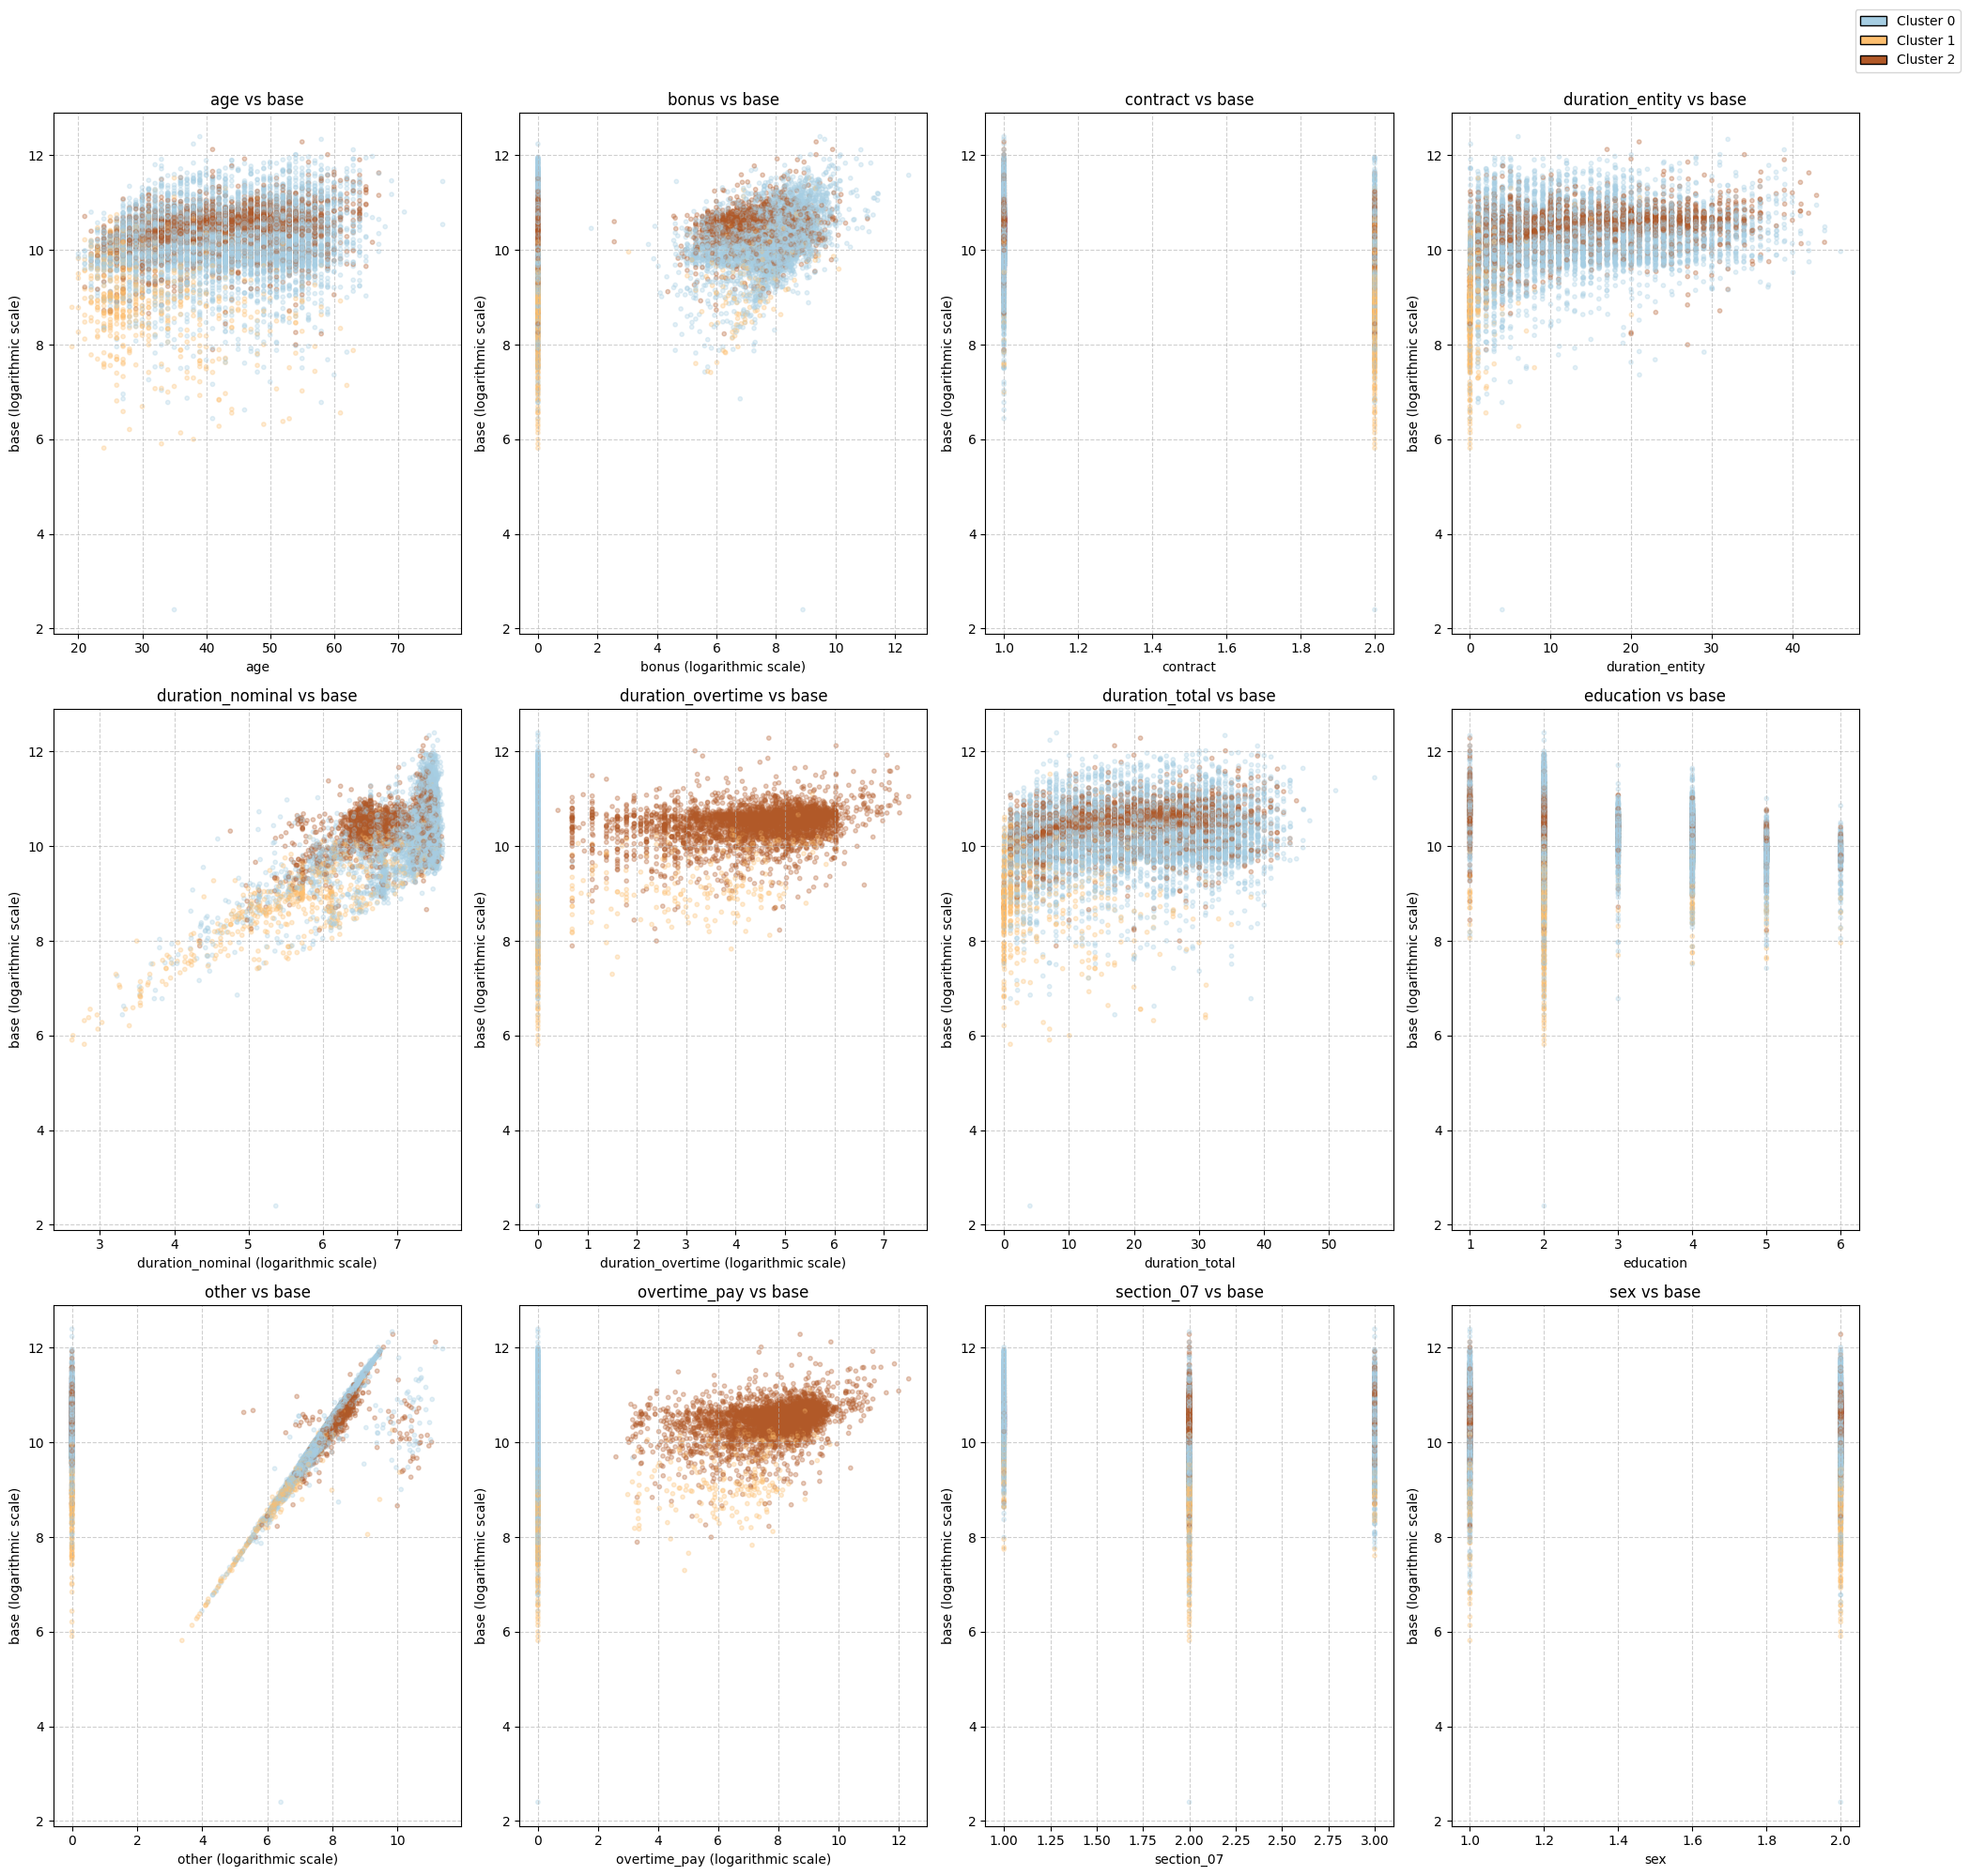

In [155]:
# Performing clustering
n_clusters = 3
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
agglomerative_labels = agglomerative.fit_predict(gower_distance_matrix)

# Plotting
plot_pairs = [
    ('age', 'base'),
    ('bonus', 'base'),
    ('contract', 'base'),
    ('duration_entity', 'base'),
    ('duration_nominal', 'base'),
    ('duration_overtime', 'base'),
    ('duration_total', 'base'),
    ('education', 'base'),
    ('other', 'base'),
    ('overtime_pay', 'base'),
    ('section_07', 'base'),
    ('sex', 'base')
]
need_log_scaling = ['base', 'bonus', 'other', 'overtime_pay', 'duration_overtime', 'duration_nominal']
X = data

cmap_name = 'Paired'
cmap = plt.get_cmap(cmap_name)

fig, axes = plt.subplots(3, 4, figsize=(20, 20))
axes = axes.flatten()

for i, pair in enumerate(plot_pairs):
    x_var, y_var = pair
    ax = axes[i]

    plot_x = X[x_var]
    plot_y = X[y_var]

    if x_var in need_log_scaling:
        plot_x = np.log1p(plot_x)
        ax.set_xlabel(f'{x_var} (logarithmic scale)')
    else:
        ax.set_xlabel(x_var)

    if y_var in need_log_scaling:
        plot_y = np.log1p(plot_y)
        ax.set_ylabel(f'{y_var} (logarithmic scale)')
    else:
        ax.set_ylabel(y_var)

    colors = [cmap(label / (n_clusters - 1)) for label in range(n_clusters)]
    scatter = ax.scatter(plot_x, plot_y, c=[colors[l] for l in agglomerative_labels], alpha=0.3, s=10)

    ax.set_title(f'{x_var} vs {y_var}')
    ax.grid(True, linestyle='--', alpha=0.6)

legend_handles = [Patch(facecolor=cmap(i / (n_clusters - 1)), edgecolor='black', label=f'Cluster {i}') for i in range(n_clusters)]
fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Comments

- Best clustering with the gower's distance is much easier to interpret, beacuse of the small number of clusters, but is significantly worse than the equivalent 3-cluster clusterings using euclidean distance and agglomerative clustering.  
  
// I only tested gower's distance with agglomerative clustering, because k-means does not allow precomputed distances and this metric is not natively supported by sklearn.

## Conclusion

Considering all the different options, I choose 3-clustering using agglomerative clustering with euclidean distance (silhouette score: 0.502) as a fair compromise between accuracy and interpretability.

Cluster 0: 3757 workers
Cluster 1: 2305 workers
Cluster 2: 4938 workers



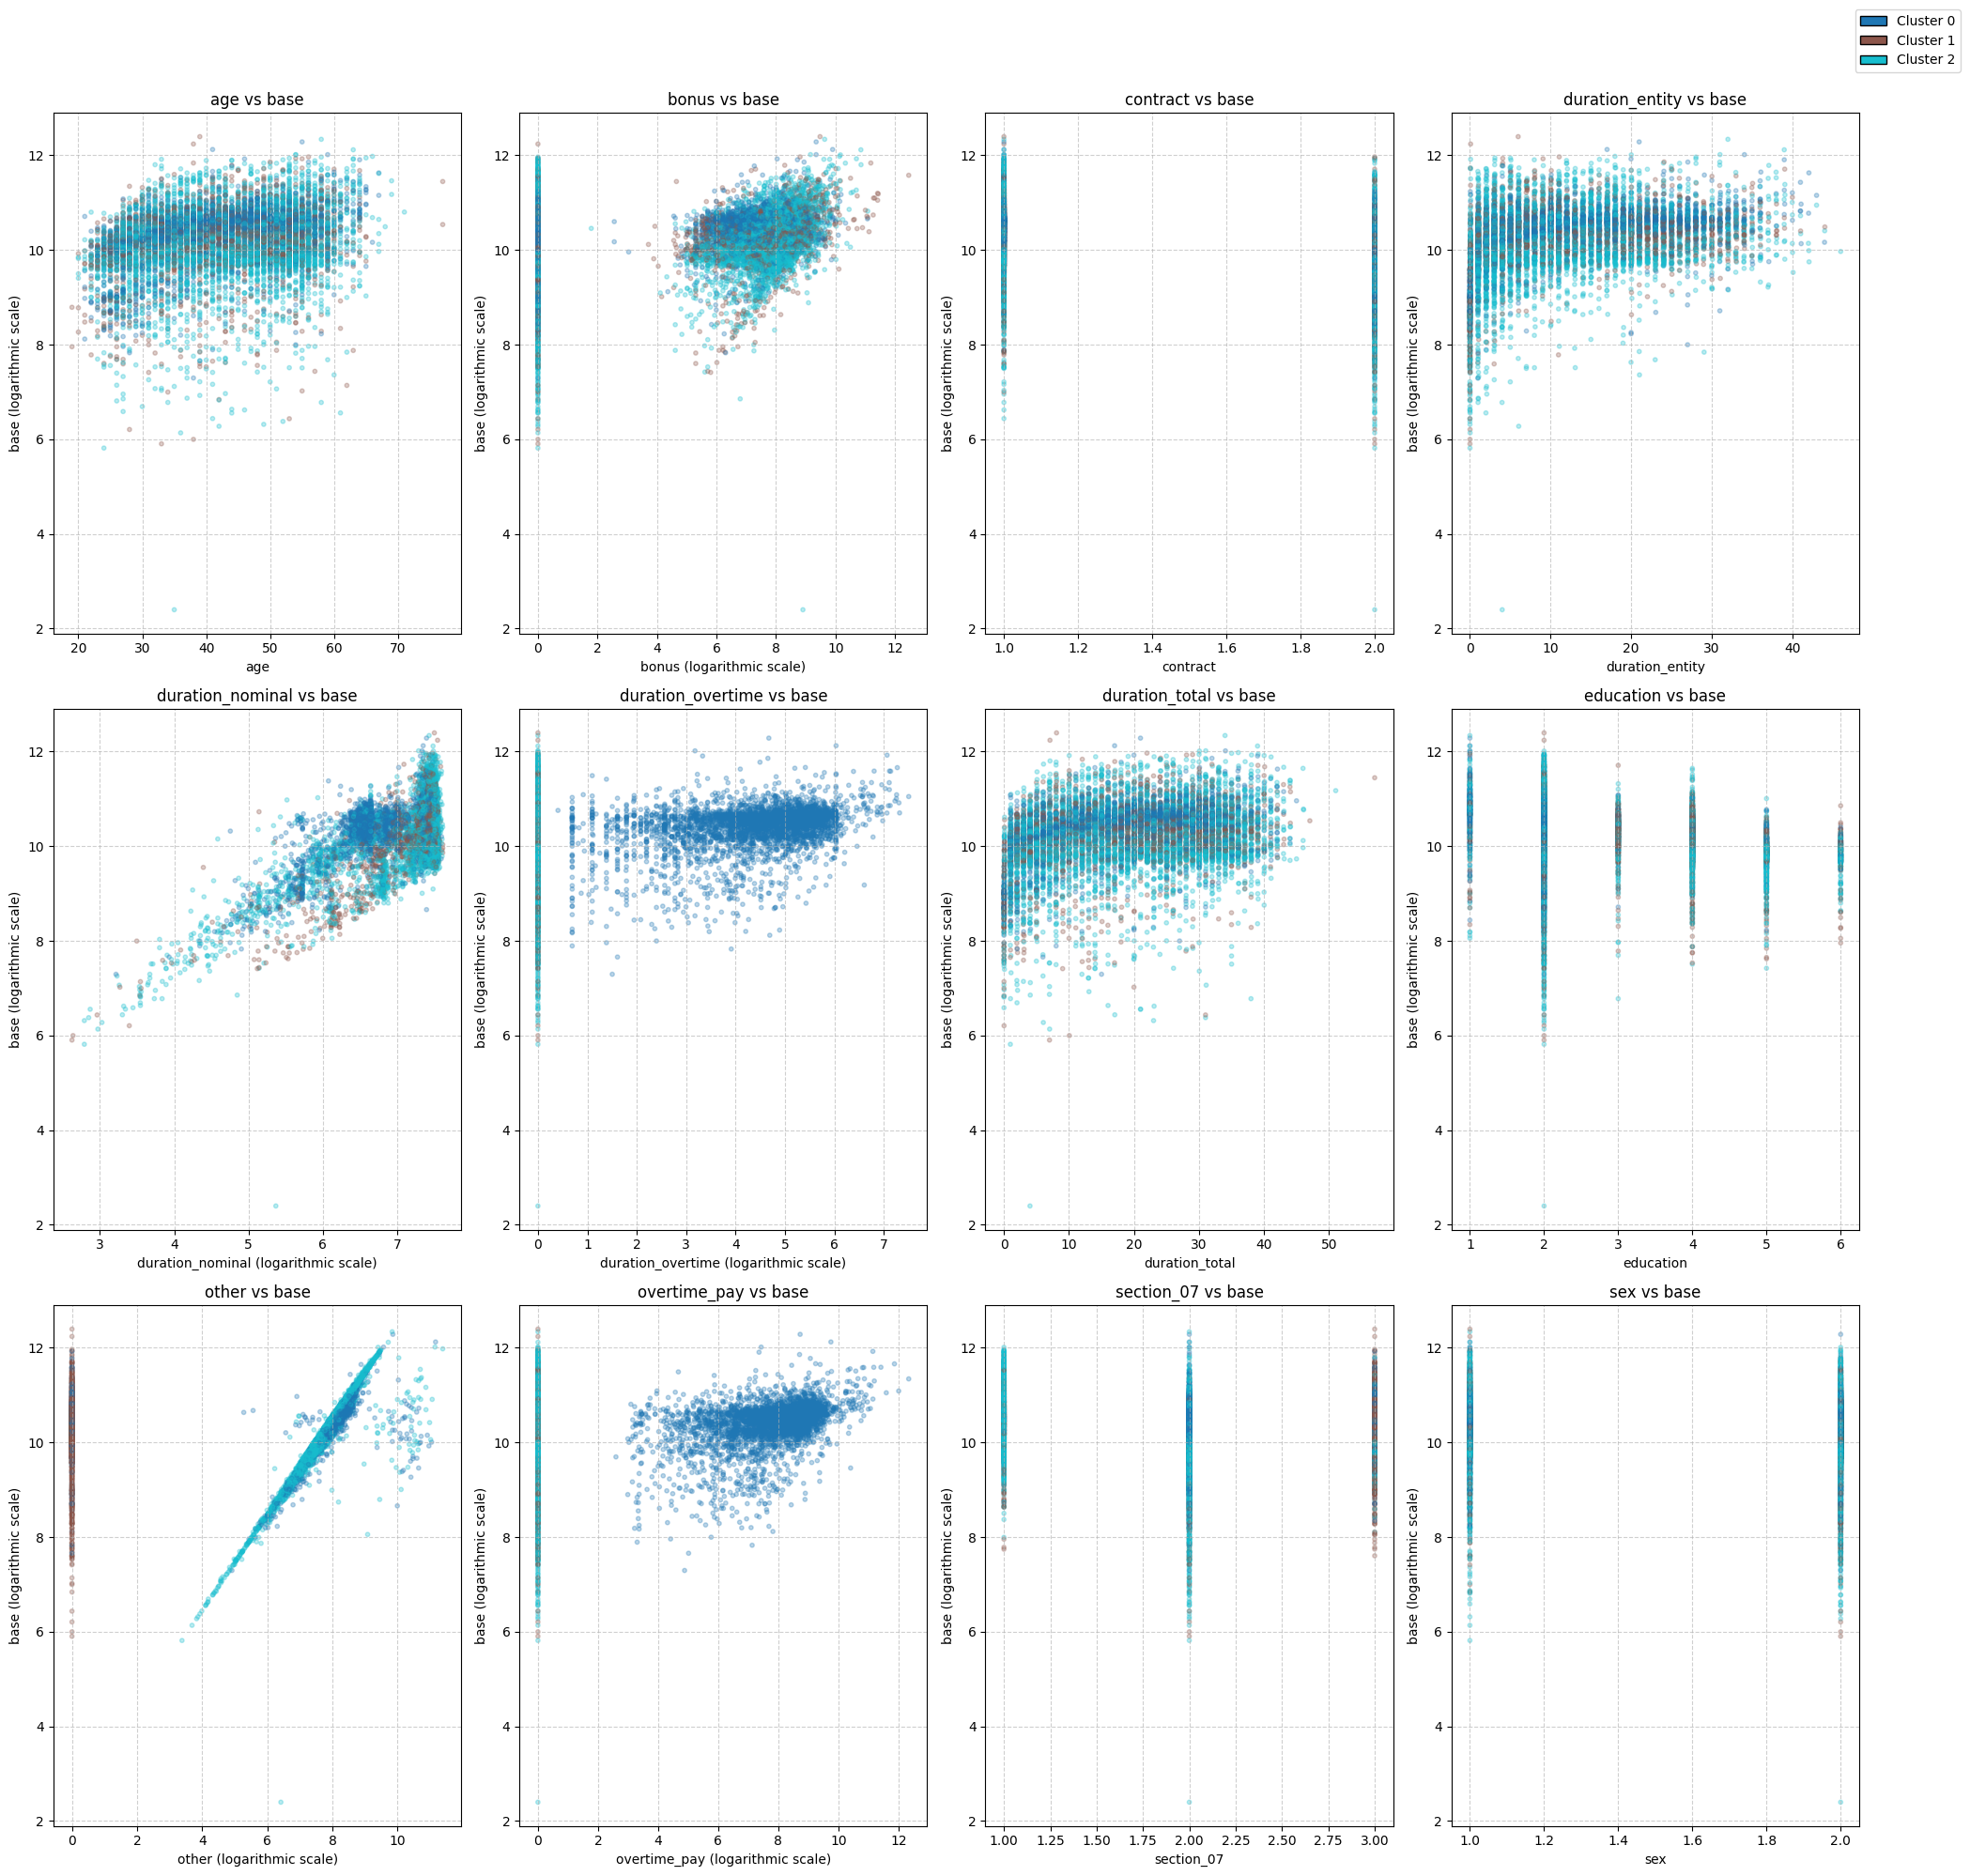

In [179]:
# Performing clustering
n_clusters = 3
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
agglomerative_labels = agglomerative.fit_predict(data_cluster)

print(f'Cluster 0: {agglomerative_labels.tolist().count(0)} workers')
print(f'Cluster 1: {agglomerative_labels.tolist().count(1)} workers')
print(f'Cluster 2: {agglomerative_labels.tolist().count(2)} workers')
print()

# Plotting
plot_pairs = [
    ('age', 'base'),
    ('bonus', 'base'),
    ('contract', 'base'),
    ('duration_entity', 'base'),
    ('duration_nominal', 'base'),
    ('duration_overtime', 'base'),
    ('duration_total', 'base'),
    ('education', 'base'),
    ('other', 'base'),
    ('overtime_pay', 'base'),
    ('section_07', 'base'),
    ('sex', 'base')
]
need_log_scaling = ['base', 'bonus', 'other', 'overtime_pay', 'duration_overtime', 'duration_nominal']
X = data

cmap_name = 'tab10'
cmap = plt.get_cmap(cmap_name)

fig, axes = plt.subplots(3, 4, figsize=(20, 20))
axes = axes.flatten()

for i, pair in enumerate(plot_pairs):
    x_var, y_var = pair
    ax = axes[i]

    plot_x = X[x_var]
    plot_y = X[y_var]

    if x_var in need_log_scaling:
        plot_x = np.log1p(plot_x)
        ax.set_xlabel(f'{x_var} (logarithmic scale)')
    else:
        ax.set_xlabel(x_var)

    if y_var in need_log_scaling:
        plot_y = np.log1p(plot_y)
        ax.set_ylabel(f'{y_var} (logarithmic scale)')
    else:
        ax.set_ylabel(y_var)

    colors = [cmap(label / (n_clusters - 1)) for label in range(n_clusters)]
    scatter = ax.scatter(plot_x, plot_y, c=[colors[l] for l in agglomerative_labels], alpha=0.3, s=10)

    ax.set_title(f'{x_var} vs {y_var}')
    ax.grid(True, linestyle='--', alpha=0.6)

legend_handles = [Patch(facecolor=cmap(i / (n_clusters - 1)), edgecolor='black', label=f'Cluster {i}') for i in range(n_clusters)]
fig.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Cluster 0 (dark blue) characteristics:  
- Overtime workers.
- High salaries, but none of them are the best earners.  
- Mainly with higher education (education= 1,2).
- With less than or equal to around 30 years of work experience.
- None of them work in Public Administration and Defence or Compulsory Social Security (section_07 != 1).
    
Cluster 1 (brown) characteristics:
- Do not recieve other forms of compensation than base salary and bonuses (other= 0).
- Nearly all of them work in Human Health and Social Work Activities (section_07= 3).
- Mostly without higher education (education >= 3).
  
Cluster 2 (light blue) characteristics:
- In this group there is a very strong positive correlation between base and other compensation.
- Big variety in working time as opposed to the other clusters.

It looks like clusters 0 and 1 actually represent specific groups of people and all the rest are grouped in cluster 2.

# Classification

## Preprocessing

In [4]:
data_class = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
epsilon = 1e-6

# Calculating target
data_class['education'] = data_class['education'].apply(lambda x: 1 if x <= 2 else 0)

# Mapping binary variables to 0/1 instead of 1/2
binary_vars = ['sector', 'sex', 'contract']
data_class[binary_vars] = data_class[binary_vars].replace({1: 0, 2: 1})

# One-hot encoding not binary qualitative variable
data_class = pd.get_dummies(data_class, columns=['section_07'])
data_class = data_class.astype({
    'section_07_1': 'int64',
    'section_07_2': 'int64',
    'section_07_3': 'int64'
})

# Logarithmic scaling quantitative variables
data_class[quant_vars] = np.log10(data_class[quant_vars] + epsilon)

data_class.drop(labels=['section_07_1'], axis=1, inplace=True)  # Can be dropped, because it's implicitly encoded in the rest of dummy variables
data_class.drop(labels=['overtime_pay'], axis=1, inplace=True)  # Can be dropped, because of a strong correlation between overtime pay and duration
data_class.drop(labels=['duration_total'], axis=1, inplace=True)  # Can be dropped, because of a strong correlation between total duration and age

# Show correlation
corr_matrix = data.corr(method='pearson', numeric_only=True)
corr_matrix[['overtime_pay', 'duration_total',]]

overtime_pay  duration_total
base                   0.184220        0.248362
bonus                 -0.054103        0.074788
overtime_pay           1.000000       -0.004601
other                  0.104176        0.095526
sector                -0.053156       -0.046569
section_07             0.084267        0.044291
sex                   -0.051895       -0.006440
education             -0.197116        0.302877
contract              -0.042420       -0.341044
age                    0.007436        0.876186
duration_total        -0.004601        1.000000
duration_entity        0.054860        0.653426
duration_nominal      -0.154939        0.240686
duration_overtime      0.865363       -0.020661

## Comments

- Logistic regression works better with scaled variables, so they are scaled logarithmically as in the previous chapter.  
- Qualitative variables are dummy encoded, because again, logistic regression requires it.
- **overtime_pay** and **duration_total** are dropped, because they are strongly correlated with other predictors. It is better for the model's accuracy and interpretability to remove them. Otherwise the coefficients would split between the correlated variables.

## Logistic regression

In [5]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_class.drop(labels=['education'], axis=1), data_class['education'], test_size=0.2, random_state=RANDOM_SEED)

# Train model
regression = LogisticRegression(
    penalty=None,
    random_state=RANDOM_SEED,
    max_iter=1000,
    solver='newton-cholesky'
)
regression.fit(x_train, y_train)

# Cross validate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

cv_scores = cross_val_score(regression, x_train, y_train, cv=cv, scoring='accuracy')
train_accuracy = regression.score(x_train, y_train)
mean_cv_accuracy = np.mean(cv_scores)
model_variance = np.var(cv_scores)

print('--- Performance ---')
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Estimated test accuracy (10-fold CV): {mean_cv_accuracy:.4f}')
print(f'Model variance (var of CV scores): {model_variance:.6f}')
print()

# Show feature importance
print('--- Coefficients ---')
for feature, coef in zip(data_class.drop(labels=['education'], axis=1).columns, regression.coef_[0]):
    print(f'{feature}: {coef:.4f}')
print(f'intercept: {regression.intercept_[0]:.4f}')

--- Performance ---
Train accuracy: 0.8676
Estimated test accuracy (10-fold CV): 0.8657
Model variance (var of CV scores): 0.000182

--- Coefficients ---
base: 9.8734
bonus: -0.0128
other: 0.0892
sector: 0.9736
sex: -0.1986
contract: 0.2538
age: -10.1790
duration_entity: -0.5139
duration_nominal: -10.5607
duration_overtime: 0.0434
section_07_2: 0.2055
section_07_3: -0.7146
intercept: 6.9557


## Comments

- The model performs well and has a very low variance.
- The most important predictors are **age**, **duration_nominal** and **base**.
- The intercept is relatively big, which makes sense considering the majority of workers in the dataset have higher education.

## Tree methods

### Preprocessing

In [9]:
data_class = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']

# Calculating target
data_class['education'] = data_class['education'].apply(lambda x: 1 if x <= 2 else 0)

# Mapping binary variables to 0/1 instead of 1/2
binary_vars = ['sector', 'sex', 'contract']
data_class[binary_vars] = data_class[binary_vars].replace({1: 0, 2: 1})

# One-hot encoding not binary qualitative variable
data_class = pd.get_dummies(data_class, columns=['section_07'])
data_class = data_class.astype({
    'section_07_1': 'int64',
    'section_07_2': 'int64',
    'section_07_3': 'int64'
})

### Comments

- Tree methods do not require variables to have the same scale, so scaling is not necessary.
- However they still need one-hot encoding of qualitative variables, because otherwise the algorithm would assume that they are ordinal (which they are not).

### Decision tree

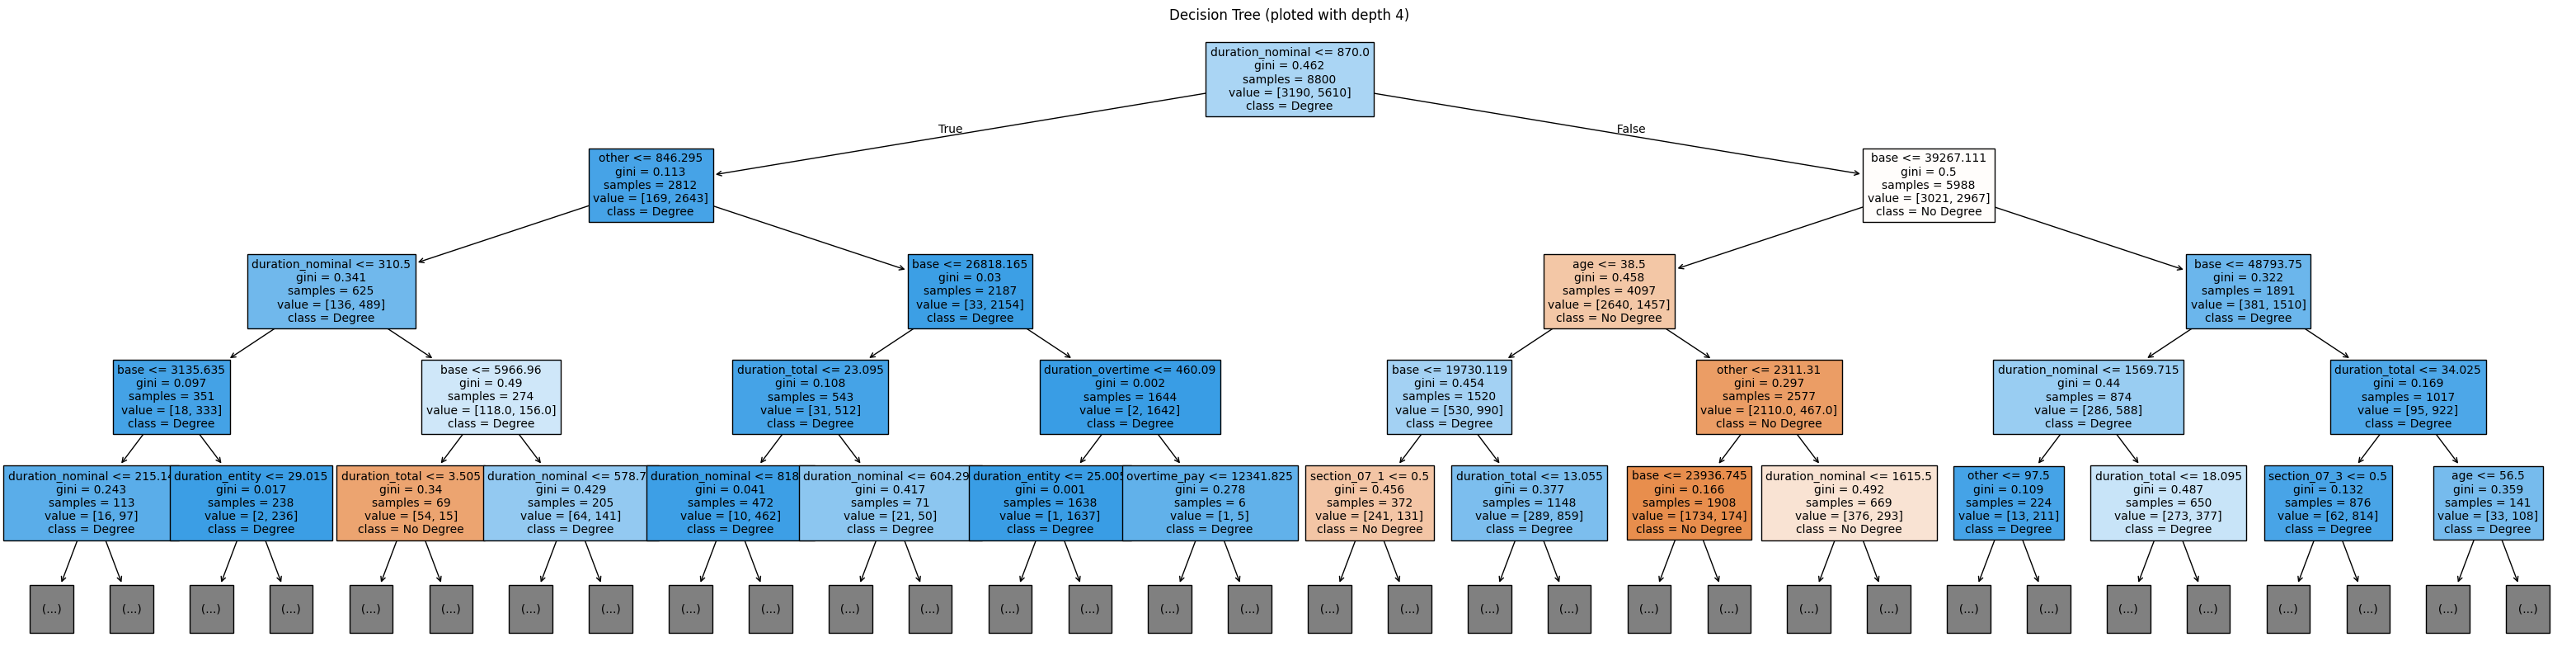


--- Performance ---
Train accuracy: 1.0000
Estimated test accuracy (10‑fold CV): 0.8357
Model variance (var of CV acc): 0.000133

-- Feature Importances (descending) --
duration_nominal: 0.2958
base: 0.2394
age: 0.1517
duration_total: 0.0986
other: 0.0807
duration_entity: 0.0465
bonus: 0.0382
section_07_3: 0.0122
sex: 0.0100
section_07_1: 0.0076
section_07_2: 0.0064
overtime_pay: 0.0058
duration_overtime: 0.0029
sector: 0.0022
contract: 0.0021


In [268]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_class.drop(labels=['education'], axis=1), data_class['education'], test_size=0.2, random_state=RANDOM_SEED)

# Train model
dtree = DecisionTreeClassifier(random_state=RANDOM_SEED)
dtree.fit(x_train, y_train)

# Plot tree
plt.figure(figsize=(40,10))
plot_tree(
    dtree,
    feature_names=data_class.drop('education', axis=1).columns,
    class_names=['No Degree','Degree'],
    filled=True,
    max_depth=4,
    fontsize=10
)
plt.title('Decision Tree (ploted with depth 4)')
plt.show()

# Cross validate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

dtree_scores = cross_val_score(
    dtree,
    x_train, y_train,
    cv=cv,
    scoring='accuracy'
)
train_accuracy = dtree.score(x_train, y_train)
mean_cv_accuracy = np.mean(dtree_scores)
model_variance = np.var(dtree_scores)

print()
print('--- Performance ---')
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Estimated test accuracy (10‑fold CV): {mean_cv_accuracy:.4f}')
print(f'Model variance (var of CV acc): {model_variance:.6f}')
print()

# Show feature importances
feat_imp = pd.Series(
    dtree.feature_importances_,
    index=data_class.drop('education', axis=1).columns
)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

print('-- Feature Importances (descending) --')
for feature, importance in feat_imp_sorted.items():
    print(f'{feature}: {importance:.4f}')


### Comments

- The training accuracy is higher than in logistic regression, but that's to be expected of decision trees. The test accuracy estimate is a bit lower.
- The top3 predictors remain the same as in logistic regression, however the order is different. Here **base** is more important than **age**.

### Random Forest

In [266]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_class.drop(labels=['education'], axis=1), data_class['education'], test_size=0.2, random_state=RANDOM_SEED)

# Train model
rforest = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rforest.fit(x_train, y_train)

# Cross validate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

cv_scores = cross_val_score(rforest, x_train, y_train, cv=cv, scoring='accuracy')
train_acc = rforest.score(x_train, y_train)
mean_cv = np.mean(cv_scores)
var_cv = np.var(cv_scores)

print('--- Performance ---')
print(f'Train accuracy: {train_acc:.4f}')
print(f'Estimated test accuracy (10‑fold CV): {mean_cv:.4f}')
print(f'Model variance (var of CV acc):  {var_cv:.6f}')
print()

# Show feature importances
feat_imp = pd.Series(
    rforest.feature_importances_,
    index=data_class.drop('education', axis=1).columns
)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

print('-- Feature Importances (descending) --')
for feature, importance in feat_imp_sorted.items():
    print(f'{feature}: {importance:.4f}')

--- Performance ---
Train accuracy: 1.0000
Estimated test accuracy (10‑fold CV): 0.8884
Model variance (var of CV acc):  0.000099

-- Feature Importances (descending) --
duration_nominal: 0.1833
base: 0.1721
other: 0.1353
duration_total: 0.1239
age: 0.0912
duration_entity: 0.0685
bonus: 0.0603
overtime_pay: 0.0498
duration_overtime: 0.0307
section_07_3: 0.0257
section_07_2: 0.0188
section_07_1: 0.0162
sex: 0.0105
contract: 0.0084
sector: 0.0052


### Comments

- Currently the highest estimated test accuracy.
- Importance of the predictors is different than before. Now **other** and **duration_total** become more important than **age**.

### Boosting

In [11]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_class.drop(labels=['education'], axis=1), data_class['education'], test_size=0.2, random_state=RANDOM_SEED)

# Find optimal learning rate with optuna
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
def objective(trial):
    lr = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_SEED),
        n_estimators=100,
        learning_rate=lr,
        random_state=RANDOM_SEED
    )

    scores = cross_val_score(ada, x_train, y_train, cv=cv, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
)
study.optimize(objective, n_trials=20)

best_lr = study.best_params['learning_rate']
print(f'AdaBoost best learning_rate: {best_lr:.4f}')

[I 2025-05-05 21:54:46,451] A new study created in memory with name: no-name-5c93afd2-8a13-4b0c-83bf-b33ce8e13934
[I 2025-05-05 21:54:59,009] Trial 0 finished with value: 0.8067045454545454 and parameters: {'learning_rate': 0.05611516415334506}. Best is trial 0 with value: 0.8067045454545454.
[I 2025-05-05 21:55:10,932] Trial 1 finished with value: 0.8626136363636363 and parameters: {'learning_rate': 0.7969454818643931}. Best is trial 1 with value: 0.8626136363636363.
[I 2025-05-05 21:55:23,346] Trial 2 finished with value: 0.8611363636363636 and parameters: {'learning_rate': 0.29106359131330695}. Best is trial 1 with value: 0.8626136363636363.
[I 2025-05-05 21:55:38,264] Trial 3 finished with value: 0.8498863636363637 and parameters: {'learning_rate': 0.15751320499779725}. Best is trial 1 with value: 0.8626136363636363.
[I 2025-05-05 21:55:51,852] Trial 4 finished with value: 0.7728409090909091 and parameters: {'learning_rate': 0.020513382630874502}. Best is trial 1 with value: 0.8626

AdaBoost best learning_rate: 0.6061


In [267]:
# Train model
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_SEED),
    n_estimators=100,
    learning_rate=best_lr,
    random_state=RANDOM_SEED
)
ada.fit(x_train, y_train)

# Cross validate
cv_scores = cross_val_score(ada, x_train, y_train, cv=cv, scoring='accuracy')
train_acc = ada.score(x_train, y_train)
mean_cv = np.mean(cv_scores)
var_cv = np.var(cv_scores)

print('--- Performance ---')
print(f'Train accuracy: {train_acc:.4f}')
print(f'Estimated test accuracy (10‑fold CV): {mean_cv:.4f}')
print(f'Model variance (var of CV acc):  {var_cv:.6f}')
print()

# Show feature importances
feat_imp = pd.Series(
    ada.feature_importances_,
    index=data_class.drop('education', axis=1).columns
)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

print('-- Feature Importances (descending) --')
for feature, importance in feat_imp_sorted.items():
    print(f'{feature}: {importance:.4f}')

--- Performance ---
Train accuracy: 0.8701
Estimated test accuracy (10‑fold CV): 0.8653
Model variance (var of CV acc):  0.000082

-- Feature Importances (descending) --
base: 0.3137
duration_nominal: 0.2844
other: 0.1102
duration_total: 0.1019
age: 0.0801
overtime_pay: 0.0708
section_07_3: 0.0168
duration_entity: 0.0118
bonus: 0.0103
sector: 0.0000
sex: 0.0000
contract: 0.0000
duration_overtime: 0.0000
section_07_1: 0.0000
section_07_2: 0.0000


### Comments

- The only tree model with train accuracy lower than 1.
- Estimated test accuracy lower than Random Forest, but simillar to logistic regression.
- Here **base** is the most important predictor and the rest from the top4 are the same as in random forest.

## Final comaprison

In [12]:
RANDOM_SEED = 112  # new seed for an interesting reveal

In [13]:
# Prepare data for logistic regression
data_class = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
epsilon = 1e-6

# Calculating target
data_class['education'] = data_class['education'].apply(lambda x: 1 if x <= 2 else 0)

# Mapping binary variables to 0/1 instead of 1/2
binary_vars = ['sector', 'sex', 'contract']
data_class[binary_vars] = data_class[binary_vars].replace({1: 0, 2: 1})

# One-hot encoding not binary qualitative variable
data_class = pd.get_dummies(data_class, columns=['section_07'])
data_class = data_class.astype({
    'section_07_1': 'int64',
    'section_07_2': 'int64',
    'section_07_3': 'int64'
})

# Logarithmic scaling quantitative variables
data_class[quant_vars] = np.log10(data_class[quant_vars] + epsilon)

# Drop unnecessary
data_class.drop(labels=['section_07_1', 'overtime_pay', 'duration_total'], axis=1, inplace=True)

# Split data
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(data_class.drop(labels=['education'], axis=1), data_class['education'], test_size=0.2, random_state=RANDOM_SEED)

In [14]:
# Prepare data for tree methods
data_class = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']

# Calculating target
data_class['education'] = data_class['education'].apply(lambda x: 1 if x <= 2 else 0)

# Mapping binary variables to 0/1 instead of 1/2
binary_vars = ['sector', 'sex', 'contract']
data_class[binary_vars] = data_class[binary_vars].replace({1: 0, 2: 1})

# One-hot encoding not binary qualitative variable
data_class = pd.get_dummies(data_class, columns=['section_07'])
data_class = data_class.astype({
    'section_07_1': 'int64',
    'section_07_2': 'int64',
    'section_07_3': 'int64'
})

# Split data
x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(data_class.drop(labels=['education'], axis=1), data_class['education'], test_size=0.2, random_state=RANDOM_SEED)

In [15]:
# Train models
reg = LogisticRegression(
    penalty=None,
    random_state=RANDOM_SEED,
    max_iter=1000,
    solver='newton-cholesky'
)
reg.fit(x_train_reg, y_train_reg)

dtree = DecisionTreeClassifier(random_state=RANDOM_SEED)
dtree.fit(x_train_tree, y_train_tree)

rforest = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rforest.fit(x_train_tree, y_train_tree)

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_SEED),
    n_estimators=100,
    learning_rate=best_lr,
    random_state=RANDOM_SEED
)
ada.fit(x_train_tree, y_train_tree)

# Test
reg_test_acc = reg.score(x_test_reg, y_test_reg)
dtree_test_acc = dtree.score(x_test_tree, y_test_tree)
rforest_test_acc = rforest.score(x_test_tree, y_test_tree)
ada_test_acc = ada.score(x_test_tree, y_test_tree)

print('--- Performance ---')
print(f'Logistic Regression test accuracy: {reg_test_acc:.4f}')
print(f'Decision Tree test accuracy: {dtree_test_acc:.4f}')
print(f'Random Forest test accuracy: {rforest_test_acc:.4f}')
print(f'AdaBoost test accuracy: {ada_test_acc:.4f}')

--- Performance ---
Logistic Regression test accuracy: 0.8559
Decision Tree test accuracy: 0.8295
Random Forest test accuracy: 0.8827
AdaBoost test accuracy: 0.8564


## Comments

Turns out that random forest classifier is the best. As predicted by cross validation.

# Regression

## Preprocessing

In [6]:
data_reg = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
epsilon = 1e-6

# Mapping binary variables to 0/1 instead of 1/2
binary_vars = ['sector', 'sex', 'contract']
data_reg[binary_vars] = data_reg[binary_vars].replace({1: 0, 2: 1})

# One-hot encoding not binary qualitative variable
data_reg = pd.get_dummies(data_reg, columns=['section_07', 'education'])
data_reg = data_reg.astype({
    'section_07_1': 'int64',
    'section_07_2': 'int64',
    'section_07_3': 'int64',
    'education_1': 'int64',
    'education_2': 'int64',
    'education_3': 'int64',
    'education_4': 'int64',
    'education_5': 'int64',
    'education_6': 'int64',
})

# Logarithmic scaling quantitative variables
data_reg[quant_vars] = np.log10(data_reg[quant_vars] + epsilon)

data_reg.drop(labels=['overtime_pay'], axis=1, inplace=True)  # Can be dropped, because of a strong correlation between overtime pay and duration
data_reg.drop(labels=['duration_total'], axis=1, inplace=True)  # Can be dropped, because of a strong correlation between total duration and age

# Show correlation
corr_matrix = data.corr(method='pearson', numeric_only=True)
corr_matrix[['overtime_pay', 'duration_total',]]

overtime_pay  duration_total
base                   0.184220        0.248362
bonus                 -0.054103        0.074788
overtime_pay           1.000000       -0.004601
other                  0.104176        0.095526
sector                -0.053156       -0.046569
section_07             0.084267        0.044291
sex                   -0.051895       -0.006440
education             -0.197116        0.302877
contract              -0.042420       -0.341044
age                    0.007436        0.876186
duration_total        -0.004601        1.000000
duration_entity        0.054860        0.653426
duration_nominal      -0.154939        0.240686
duration_overtime      0.865363       -0.020661

## Comments

- The preprocessing is the same as in the previous chapter for logistic regression. The only difference being that education is now a predictor, so it needs to be one-hot encoded.

## Feature selection

In [ ]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_reg.drop(labels=['base'], axis=1), data_reg['base'], test_size=0.2, random_state=RANDOM_SEED)

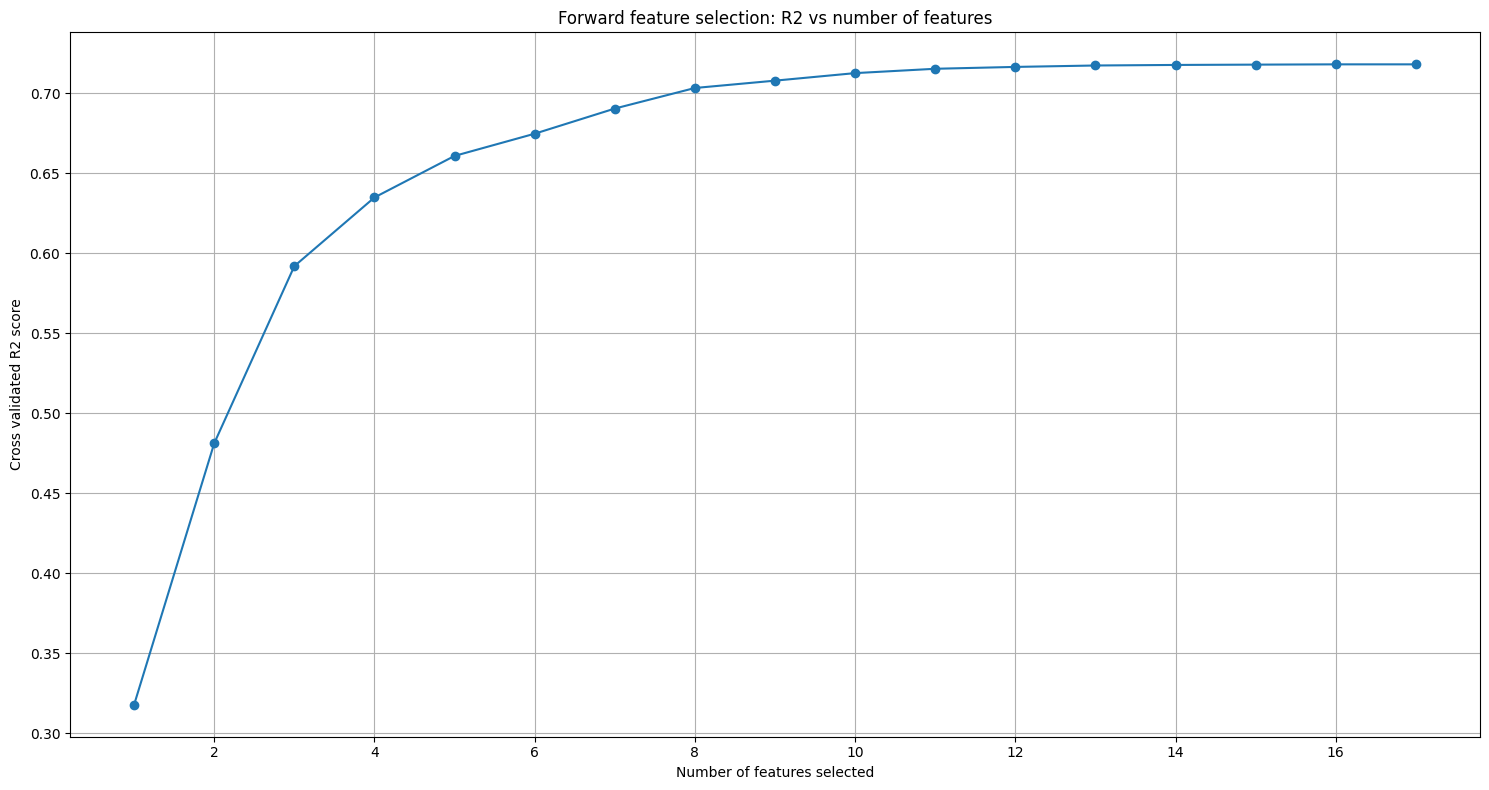

In [24]:
# Try forward feature selection
regressor = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)


selector = SequentialFeatureSelector(
    regressor,
    n_features_to_select='auto',
    direction='forward',
    scoring='r2',
    cv=cv
)

r2_scores = []
feature_counts = list(range(1, x_train.shape[1]))

for n_features in feature_counts:
    selector = SequentialFeatureSelector(
        regressor,
        n_features_to_select=n_features,
        direction='forward',
        scoring='r2',
        cv=cv
    )
    selector.fit(x_train, y_train)
    score = cross_val_score(regressor, x_train.iloc[:, selector.get_support()], y_train, cv=cv, scoring='r2')
    r2_scores.append(np.mean(score))


plt.figure(figsize=(15, 8))
plt.plot(feature_counts, r2_scores, marker='o')
plt.xlabel('Number of features selected')
plt.ylabel('Cross validated R2 score')
plt.title('Forward feature selection: R2 vs number of features')
plt.grid(True)
plt.tight_layout()
plt.show()

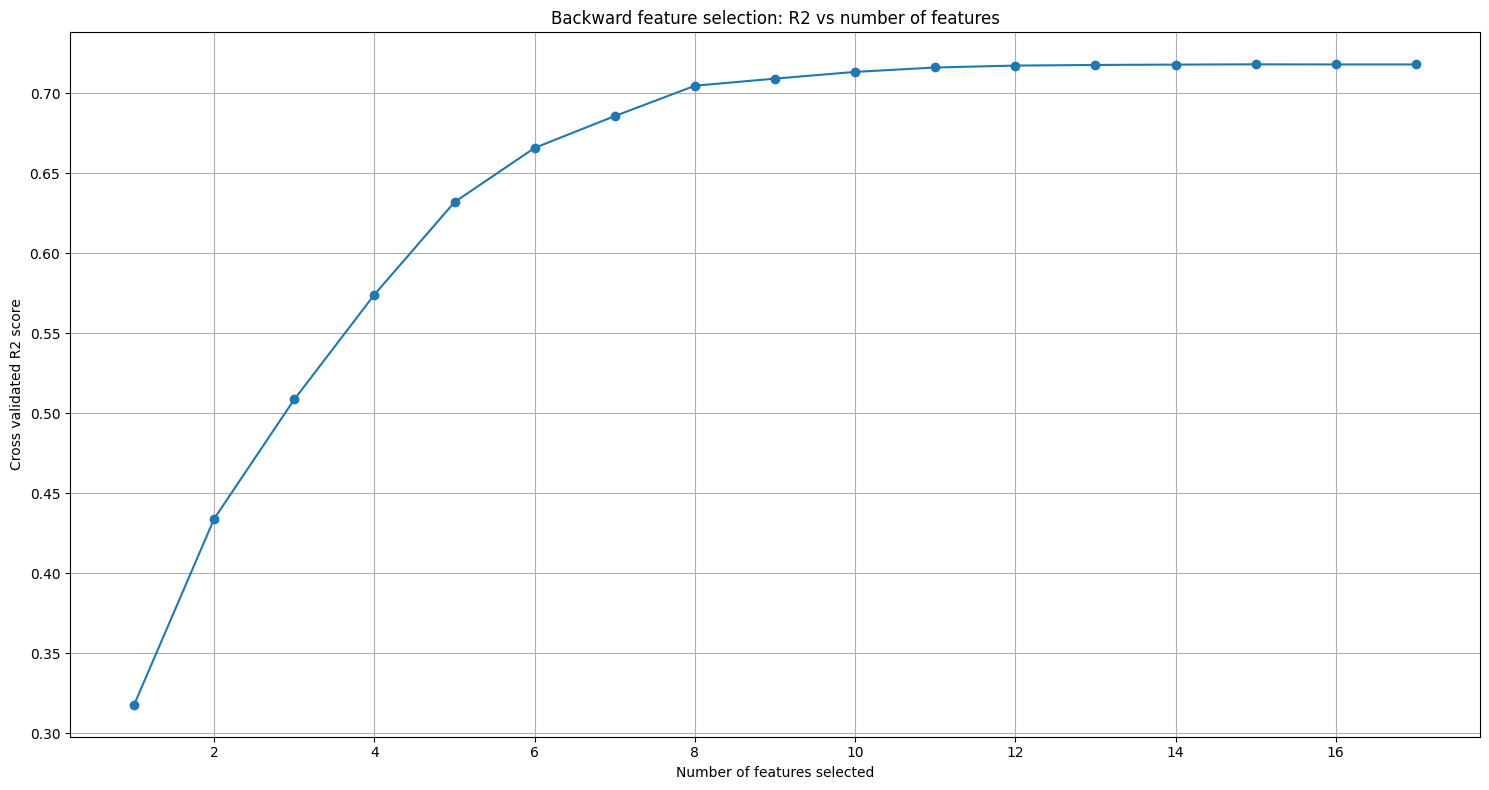

In [21]:
# Try backward feature selection
regressor = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

selector = SequentialFeatureSelector(
    regressor,
    n_features_to_select='auto',
    direction='backward',
    scoring='r2',
    cv=cv
)

r2_scores = []
feature_counts = list(range(1, x_train.shape[1]))

for n_features in feature_counts:
    selector = SequentialFeatureSelector(
        regressor,
        n_features_to_select=n_features,
        direction='backward',
        scoring='r2',
        cv=cv
    )
    selector.fit(x_train, y_train)
    score = cross_val_score(regressor, x_train.iloc[:, selector.get_support()], y_train, cv=cv, scoring='r2')
    r2_scores.append(np.mean(score))

plt.figure(figsize=(15, 8))
plt.plot(feature_counts, r2_scores, marker='o')
plt.xlabel('Number of features selected')
plt.ylabel('Cross validated R2 score')
plt.title('Backward feature selection: R2 vs number of features')
plt.grid(True)
plt.tight_layout()
plt.show()

## Comments

- Both forward and backward selection heuristics seem to have a plateau at 0.7 R2.
- I think 8 features is a good compromise between the simplicity of the model and it's score.  
  
// I'm not using more sophisticated regularization or dimension reduction methods, because they are listed later in the course and I assumed they are outside of the scope of this assignment.

## Linear regression

In [38]:
# Choose predictors
regressor = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
selector = SequentialFeatureSelector(
    regressor,
    n_features_to_select=8,
    direction='forward',
    scoring='r2',
    cv=cv
)

selector.fit(x_train, y_train)
selected_features = x_train.columns[selector.get_support()]

print('--- Selected features ----')
for feature in selected_features:
    print(feature)
print()

# Train model
regressor.fit(x_train[selected_features], y_train)

# Show coefficients
coefficients = list(zip(selected_features, regressor.coef_))
sorted_coefficients = sorted(coefficients, key=lambda item: abs(item[1]), reverse=True)

print('--- Coefficients ---')
for feature, coef in sorted_coefficients:
    print(f'{feature}: {coef:.4f}')
print(f'intercept: {regressor.intercept_:.4f}')
print()

# Test
test_score = regressor.score(x_test[selected_features], y_test)
y_pred = regressor.predict(x_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('--- Performance ---')
print(f'Test R2 score: {test_score:.4f}')
print(f'Test RMSE: {rmse:.4f}')

--- Selected features ----
age
duration_entity
duration_nominal
duration_overtime
education_1
education_2
education_5
education_6

--- Coefficients ---
duration_nominal: 0.6974
age: 0.4335
education_1: 0.2257
education_2: 0.2251
education_6: -0.1889
education_5: -0.1661
duration_entity: 0.0923
duration_overtime: 0.0147
intercept: 1.4723

--- Performance ---
Test R2 score: 0.6932
Test RMSE: 0.1509


## Comments

The model suggests that to earn more a worker should:
- Work more hours.
- Be older.
- Have a higher education.
- Stay longer with one employer.
- Work overtime.
  
Middle school or lower education level seem to be a negative predictor in that regard.


## Preprocessing

In [ ]:
data_reg = data.copy()
qual_vars = ['sector', 'section_07', 'sex', 'education', 'contract']
quant_vars = ['base', 'bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']

# Mapping binary variables to 0/1 instead of 1/2
binary_vars = ['sector', 'sex', 'contract']
data_reg[binary_vars] = data_reg[binary_vars].replace({1: 0, 2: 1})

# One-hot encoding not binary qualitative variable
data_reg = pd.get_dummies(data_reg, columns=['section_07', 'education'])
data_reg = data_reg.astype({
    'section_07_1': 'int64',
    'section_07_2': 'int64',
    'section_07_3': 'int64',
    'education_1': 'int64',
    'education_2': 'int64',
    'education_3': 'int64',
    'education_4': 'int64',
    'education_5': 'int64',
    'education_6': 'int64',
})

## Comments

- Preprocessing for random forest as a regression method is the same as for classification.

## Random forest

In [40]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_reg.drop(labels=['base'], axis=1), data_reg['base'], test_size=0.2, random_state=RANDOM_SEED)

# Train model
rforest = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
rforest.fit(x_train, y_train)

# Show feature importance
feat_imp = pd.Series(
    rforest.feature_importances_,
    index=data_reg.drop('base', axis=1).columns
)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

print('--- Feature importances ---')
for feature, importance in feat_imp_sorted.items():
    print(f'{feature}: {importance:.4f}')
print()

# Test
test_score = rforest.score(x_test, y_test)
y_pred = rforest.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('--- Performance ---')
print(f'Test R2 score: {test_score:.4f}')
print(f'Test RMSE: {rmse:.4f}')

--- Feature importances ---
other: 0.4349
duration_nominal: 0.4315
duration_entity: 0.0317
bonus: 0.0252
age: 0.0233
duration_overtime: 0.0130
education_2: 0.0122
education_1: 0.0052
sector: 0.0040
education_5: 0.0038
education_6: 0.0031
sex: 0.0030
contract: 0.0029
section_07_2: 0.0022
section_07_3: 0.0015
section_07_1: 0.0011
education_4: 0.0008
education_3: 0.0005

--- Performance ---
Test R2 score: 0.9071
Test RMSE: 0.0830


## Comments

- Random forest performed significantly better than linear regression.
- Only 7 predictors have a significance greater than 0.01.
- Suprisingly the most important feature in this model was eliminated by feature selection in linear regression.